# Final Analysis and Thermodynamics of Ising Model

I'm gonna do the actual data analysis on MC simulation for square lattice of $(L,L)$ dimension , for L that goes from $10$ to $70$ in steps of $5$, each simulation consists in $2*10^{6}$ calls of the $\verb|Metropolis()|$ function that does an update of the lattice ($L*L$ local updates). 
<br>
Measures are taken every $25$ MC steps

In [1]:
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm
import os
import matplotlib as mpt
import matplotlib.pyplot as plt
from matplotlib import style
import pylab
#speed things up
import numba
from numba import njit
from numba import jit
from numba import prange
from scipy.optimize import curve_fit
#from numba_progress import ProgressBar
#from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer
from time import sleep
#style designed by me for plottin (version 2)
plt.style.use(['science','notebook','grid'])
plt.rcParams['mathtext.fontset'] = 'stix'

fig = (9,6)
params = {'figure.figsize': fig,
        'legend.fontsize': 2.5*fig[1],
         'axes.labelsize': 2.8*fig[1],
         'axes.titlesize':4*fig[1],
         'xtick.labelsize':2*fig[1],
         'ytick.labelsize':2*fig[1],
         'font.family' : 'Stixgeneral'
          }
pylab.rcParams.update(params)


In [2]:
def getColor(c, N, idx):
    cmap=mpt.colormaps.get_cmap(c)
    norm = mpt.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

In [3]:
beta_exp = np.round(np.arange(0.3,0.55,0.002), decimals=3)

In [4]:
files = np.arange(10,75,5)
for file in tqdm(files):
    filename = f"simulation_{file}.txt"
    bs, es, ms = np.loadtxt(filename, unpack=True)
    if (file==10):
        energy_mat = np.zeros((len(bs),len(files)+1))
        magnes_mat = np.zeros((len(bs),len(files)+1)) 

    energy_mat[:,int(file/5-2)] = es
    magnes_mat[:,int(file/5-2)] = ms

  0%|          | 0/13 [00:00<?, ?it/s]

In [5]:
2000000/25 * len(beta_exp),len(bs)

(10080000.0, 10080000)

In [5]:
@jit
def data_asmatrix(files, beta_exp, energy_mat, magnes_mat):
    magns_L=np.zeros((len(beta_exp),len(files)))
    var_magns_L=np.zeros((len(beta_exp),len(files)))
    for i in range(0,len(files)):
        as_matrix = np.column_stack((bs,magnes_mat[:,i]))
        m=[]
        v=[]
        for b in (beta_exp):
            indices = as_matrix[:,0]
            mgns = np.sum(np.abs(as_matrix[(indices == b),1]))      # here one can 
            var=np.var(np.abs(as_matrix[(indices == b),1])[3000:])  # select the initial steps 
            mgns = mgns/(len(as_matrix[(indices == b),1]))          # which have to be neglected
            m.append(mgns)                                          #i.e. the point in the Markov-chain where to start averag, var ecc..
            v.append(var)
        magns_L[:,i]=m
        var_magns_L[:,i]=v
    return magns_L, var_magns_L

In [6]:
%time magns_L, var_magns_L = data_asmatrix(files, beta_exp, energy_mat, magnes_mat)

CPU times: user 52.1 s, sys: 5.94 s, total: 58 s
Wall time: 58.6 s


In [7]:
files = np.arange(10,75,5)
for file in files:
    plt.plot(beta_exp, magns_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.3',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))

plt.legend()    
plt.show()

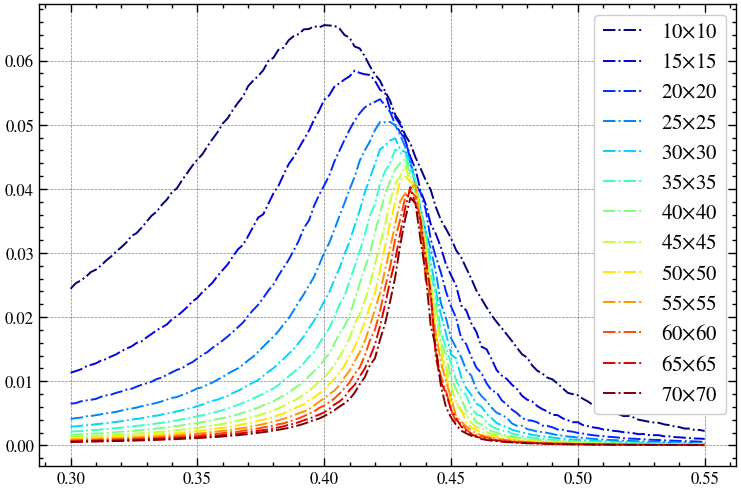

In [27]:
files = np.arange(10,75,5)
for file in files:
    i=int()
    plt.plot(beta_exp, var_magns_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.4',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))

plt.legend()    
plt.show()

In [ ]:
file=55
plt.plot(beta_exp, var_magns_L[:,int(file/5 - 2)],'+',markersize='5', linewidth='0.7',label=rf'{file}$ \times ${file}')

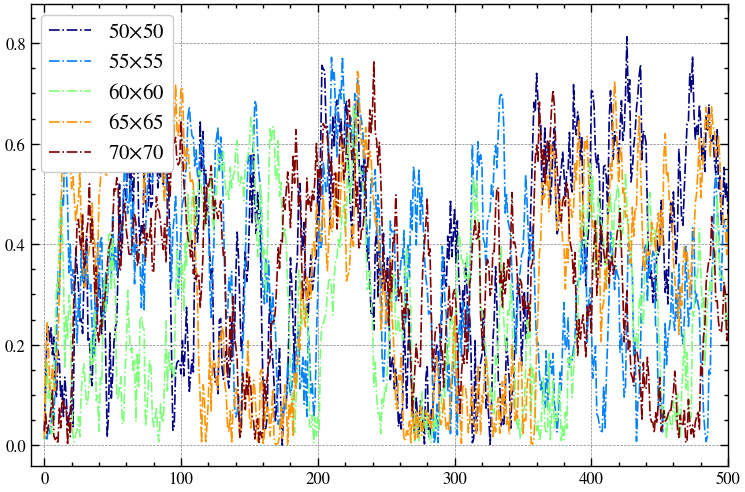

In [84]:
#storie mc per grossi reticoli e grossi beta
as_matrix = np.column_stack((bs,magnes_mat[:,0]))
ind = as_matrix[:,0]
files=np.arange(50,75,5)
for file in files: plt.plot(np.abs(magnes_mat[ind==0.43,int(file/5 - 2)]),'-.',markersize='6', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(((file-(files[0]-10)))/5 - 2)))
plt.xlim(-10,500)
plt.legend()
plt.show()



In [18]:
#storie mc per grossi reticoli e grossi beta
as_matrix = np.column_stack((bs,magnes_mat[:,0]))
ind = as_matrix[:,0]
files=np.arange(50,75,5)
for file in files: plt.plot(np.abs(magnes_mat[ind==0.55,int(file/5 - 2)]),'-.',markersize='9', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(((file-(files[0]-10)))/5 - 2)))
#plt.xlim(-50,600)
plt.legend()
plt.show()


In [39]:
#NOw let's collect all the data both magnetization and energy and then calculate the susceptibility
beta_exp = np.round(np.arange(0.3,0.55,0.002), decimals=3)
files = np.arange(10,75,5)
@njit
def data_asmatrix(files, beta_exp, energy_mat, magnes_mat, N):
    magns_L = np.zeros((len(beta_exp),len(files)))
    enes_L = np.zeros((len(beta_exp),len(files)))
    heatc_L = np.zeros((len(beta_exp),len(files)))
    chi_L = np.zeros((len(beta_exp),len(files)))
    #var_magns_L=np.zeros((len(beta_exp),len(files)))
    for file in files:
        i = int(file/5-2)
        as_matrix_m = np.column_stack((bs,magnes_mat[:,i]))
        as_matrix_e = np.column_stack((bs,energy_mat[:,i]))
        m,vm = [],[]
        e, ve = [],[]
        for b in (beta_exp):
            indices = as_matrix_m[:,0]
            
            Nm = len(as_matrix_m[(indices == b),1][N:])
            Ne = len(as_matrix_e[(indices == b),1][N:])
            mgns = np.sum(np.abs(as_matrix_m[(indices == b),1][N:]))/Nm      
            enes = np.sum(as_matrix_e[(indices == b),1][N:])/Ne 
            heat_c = (np.sum((as_matrix_e[(indices == b),1][N:])**2)/Ne - (np.sum(as_matrix_e[(indices == b),1][N:])/Ne)**2)*file**2
            chi = (np.sum((as_matrix_m[(indices == b),1][N:])**2)/Nm - (np.sum(np.abs(as_matrix_m[(indices==b),1][N:]))/Nm)**2)*file**2
            ve.append(heat_c)
            vm.append(chi)
            m.append(mgns)                                           
            e.append(enes)
                 
        magns_L[:,i] = m
        enes_L[:,i] = e
        heatc_L[:,i] = ve
        chi_L[:,i] = vm
        
                 
    return magns_L, enes_L, heatc_L, chi_L

In [36]:
%time magns_L, enes_L, heatc_L, chi_L = data_asmatrix(files, beta_exp, energy_mat, magnes_mat, 0)

CPU times: user 2min 12s, sys: 12.2 s, total: 2min 24s
Wall time: 2min 24s


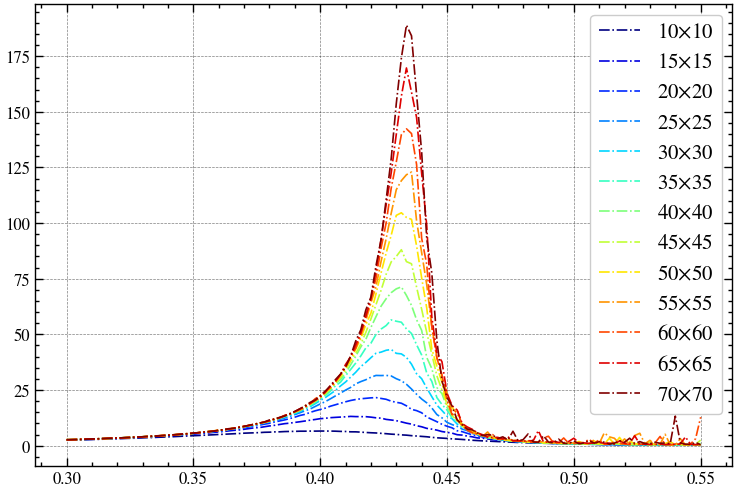

In [37]:
for file in files: 
    plt.plot(beta_exp, chi_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()
plt.show()

In [40]:
%time magns_Lf, enes_Lf, heatc_Lf, chi_Lf = data_asmatrix(files, beta_exp, energy_mat, magnes_mat, 10000)

CPU times: user 2min 8s, sys: 12.1 s, total: 2min 20s
Wall time: 2min 20s


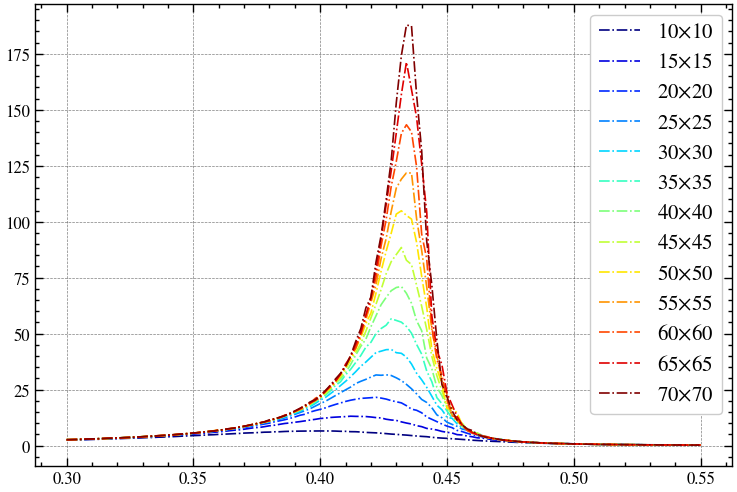

In [41]:
#tolto 10000 punti iniziali
for file in files: 
    plt.plot(beta_exp, chi_Lf[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()
plt.show()

In [28]:
def binned_bootstrap(data, bin_size, num_samples):
    # Calculate the number of bins.
    num_bins = int(np.ceil(len(data) / bin_size))

    # Create an array to store the bootstrap samples.
    bootstrap_samples = np.zeros((num_samples, len(data)))

    # Generate the bootstrap samples.
    for i in range(num_samples):
        # Sample with replacement from the bins.
        bin_indices = np.random.randint(num_bins, size=num_bins)
        bootstrap_bins = [data[bin_size*bi:bin_size*(bi+1)] for bi in bin_indices]
        # store the sample.
        bootstrap_samples[i] = np.concatenate(bootstrap_bins)

    return bootstrap_samples

In [8]:
n=80000
n.bit_length()-1, 2**16,80000-65536

(16, 65536, 14464)

In [ ]:
energy_mat[:,L] magnes_mat[:,L]

In [29]:
@njit #ricorda il valore assoluto magn quando chiami 
def bootstrap(boot):
    aver = np.zeros(boot.shape[0])
    d_aver = np.zeros(boot.shape[0])
    dd_aver = np.zeros(boot.shape[0])
    for i in range(0,boot.shape[0]):
        aver[i] = np.sum(boot[i])/boot.shape[1]   #average per campiionamento
        d_aver[i] = np.sum(boot[i]**2)/boot.shape[1] - (np.sum(boot[i])/boot.shape[1])**2
    
    average = np.sum(aver)/boot.shape[0]
    d_average = np.sum(d_aver)/boot.shape[0]    
    dx1 = 0
    dx = 0
    for i in range(0,boot.shape[0]):
        dx1 += (d_aver[i] - d_average)**2
        dx += (aver[i] - average)**2
    dx = np.sqrt(dx/(boot.shape[0]-1))
    dx1 = np.sqrt(dx/(boot.shape[0]-1))
    
    return dx,dx1        

    
    

In [135]:
beta_exp = np.round(np.arange(0.3,0.55,0.002), decimals=3)
files = np.arange(10,75,5)

In [246]:
files = np.arange(10,75,5)
magns_L = np.zeros((len(beta_exp),len(files)))
enes_L = np.zeros((len(beta_exp),len(files)))
heatc_L = np.zeros((len(beta_exp),len(files)))
chi_L = np.zeros((len(beta_exp),len(files)))
dmagns_L = np.zeros((len(beta_exp),len(files)))
denes_L = np.zeros((len(beta_exp),len(files)))
dheatc_L = np.zeros((len(beta_exp),len(files)))
dchi_L = np.zeros((len(beta_exp),len(files)))
N=5000

for file in tqdm(files):
    i = int(file/5-2)
    m, cchi, dm, dchi  = [],[],[],[]
    e, hc, de, dhc = [],[],[],[]
    for b in beta_exp:
        
        Nm = len(magnes_mat[(bs == b),i][N:])
        Ne = len(energy_mat[(bs == b),i][N:])
        mgns = np.sum(np.abs(magnes_mat[(bs == b),i][N:]))/Nm      
        enes = np.sum(energy_mat[(bs == b),i][N:])/Ne 
        heat_c = (np.sum((energy_mat[(bs == b),i][N:])**2)/Ne - (np.sum(energy_mat[(bs == b),i][N:])/Ne)**2)*file**2
        chi = (np.sum((magnes_mat[(bs == b),i][N:])**2)/Nm - (np.sum(np.abs(magnes_mat[(bs==b),i][N:]))/Nm)**2)*file**2
        
        
        boot_m = binned_bootstrap(np.abs(magnes_mat[bs==b,i][N:]), 2500, 2000)
        boot_e =binned_bootstrap(energy_mat[bs==b,i][N:], 2500, 2000)
        d_e, d_e1 = bootstrap(boot_e)
        d_m, d_m1 = bootstrap(boot_m)
        hc.append(heat_c)
        cchi.append(chi)
        m.append(mgns)                                           
        e.append(enes)
        dm.append(d_m)
        dchi.append(d_m1*file**2)
        de.append(d_e)
        dhc.append(d_e1*file**2)
    magns_L[:,i] = m
    enes_L[:,i] = e
    heatc_L[:,i] = hc
    chi_L[:,i] = cchi
    dmagns_L[:,i] = dm
    denes_L[:,i] = de
    dheatc_L[:,i] = dhc
    dchi_L[:,i] = dchi
        


  0%|          | 0/13 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


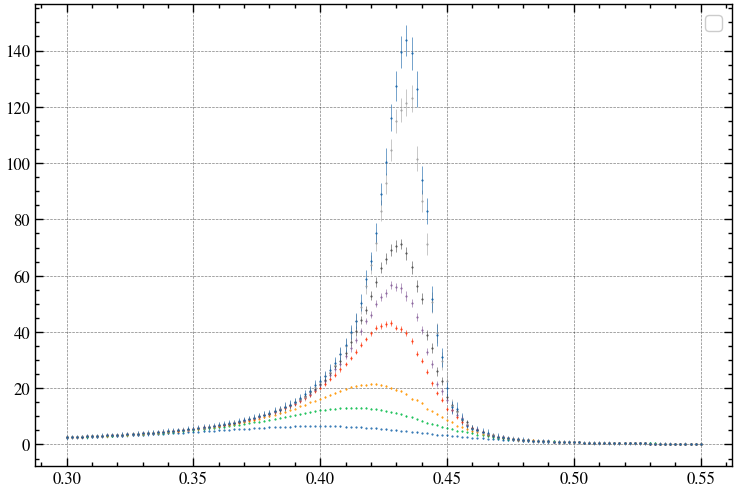

In [249]:
#plt.plot(beta_exp,dchi_L[:,0],label='1')
#plt.plot(beta_exp,dchi_L[:,1],label='2')
plt.errorbar(beta_exp, chi_L[:,0], dchi_L[:,0],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,1], dchi_L[:,1],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,2], dchi_L[:,2],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,4], dchi_L[:,4],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,5], dchi_L[:,5],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,6], dchi_L[:,6],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,9], dchi_L[:,9],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,10], dchi_L[:,10],fmt='.', elinewidth=.4,markersize=1)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


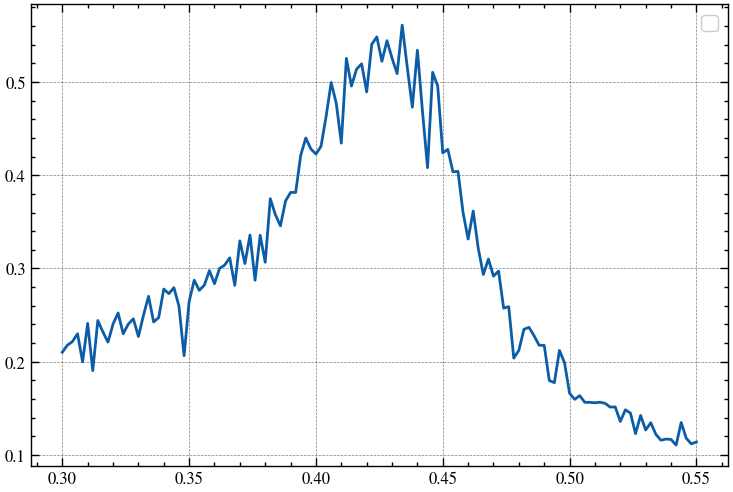

In [244]:
plt.plot(beta_exp,dchi_L[:,2])
plt.legend()

In [28]:
def write_file(bet, x, dx, name, firstrow):
    filepath =f'{name}.txt'
    with open(filepath, "w") as file:
        file.write('#' + '\t\t'.join(firstrow.split())+'\n')
        if (len(x)==len(dx)==len(bet) and len(firstrow.split())==3):
            for bi, xi, dxi in zip(bet, x, dx):
                file.write(f'{bi}\t\t{xi}\t\t{dxi}\n')     
        else: print('Errore!!! Problem in the shape of the args')

In [29]:
def threading(bet, x, dx, name, firstrow, files):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i,file in enumerate(files):
            fullname =f'{name}_{file}'
            executor.submit(write_file, bet, x[:,i], dx[:,i], fullname, firstrow)
        

In [30]:
os.mkdir('data_6272')
path = os.getcwd() + '/data_6272'

In [37]:
direct = '/energy'
os.mkdir(path + direct)
names = path + '/'+ direct +'/' + 'ene'
%time threading(beta_exp, enes_L, denes_L , names, 'betas ene dene', files)

CPU times: user 9.58 ms, sys: 6.97 ms, total: 16.6 ms
Wall time: 11.8 ms


In [11]:
a=int(2*10**6/25)
a.bit_length()

17

In [19]:
70000 - 2**16

4464

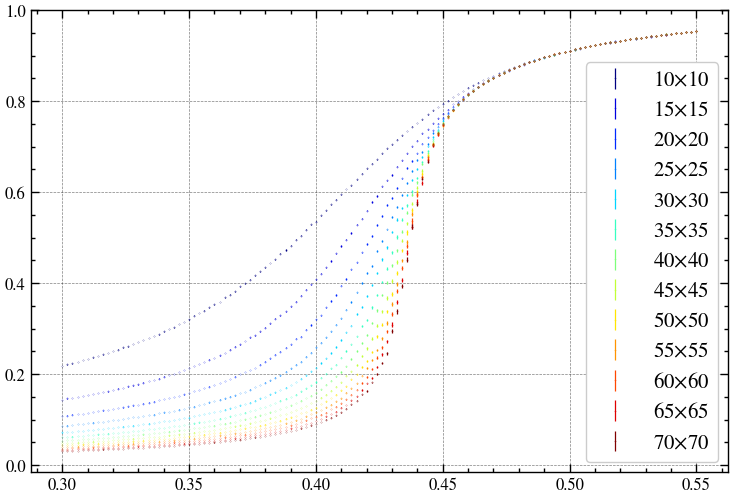

In [38]:
names = os.getcwd() + '/data_6272/' + 'magn' + '/' + 'magn_'
for file in files:
    filename = f'{names}{file}.txt'
    betas, m, dm = np.loadtxt(filename, unpack=True)
    plt.errorbar(betas, m, dm,fmt='.', elinewidth=.9,markersize=.3,label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()

plt.show()

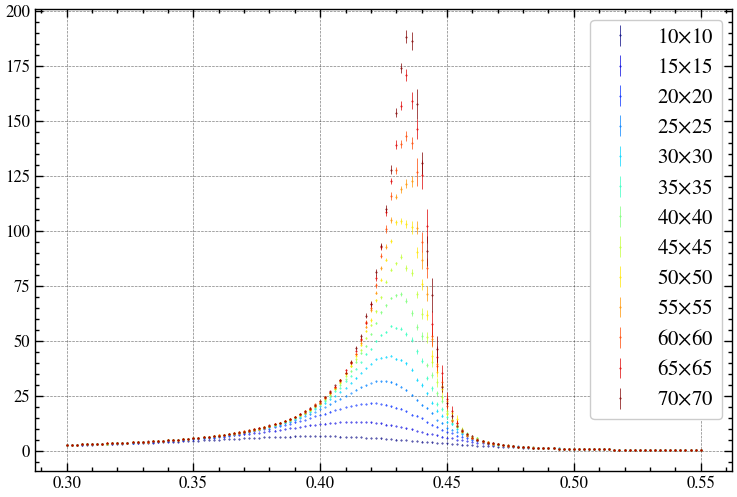

In [39]:
# sostituire /data_6272/ con '/' per avere quelli con N = 50000
names = os.getcwd() + '/data_6272/' + 'susceptibility' + '/' + 'chi_'
for file in files:
    filename = f'{names}{file}.txt'
    betas, m, dm = np.loadtxt(filename, unpack=True)
    plt.errorbar(betas, m, dm,fmt='.', elinewidth=.5,markersize=.8,label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()

plt.show()

In [8]:
def blocking(data, bin_size):
    nb = int(len(data)/bin_size) #num of blocks
    #lets build the blocks with list comprehension
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    averages = np.array([b.mean() for b in blocks]) #average for each block
    return averages.std(ddof=1)/np.sqrt(nb) if nb > 1 else 0

In [9]:
def bootstrap_binned(data, bin_size, f, R):
    nb = int(len(data)/bin_size) #num of blocks
    re_samples = np.full(R,0.) #each row will contain the fake resampling std
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    #let's pick randomly the block until all the sample is full
    tmp = np.full((nb,bin_size), 0.)
    for j in range(R):
        for k, b in enumerate(np.random.randint(0, nb, size=nb)):
            tmp[k] = blocks[b]
        re_samples[j] = f(tmp.flatten())
    return re_samples

In [10]:
def var_abs(data):
    return abs(data).std(ddof=1)**2

In [11]:
80000 - 2**16

14464

In [83]:
files = np.arange(10,75,5)
magns_L = np.zeros((len(beta_exp),len(files)))
enes_L = np.zeros((len(beta_exp),len(files)))
heatc_L = np.zeros((len(beta_exp),len(files)))
chi_L = np.zeros((len(beta_exp),len(files)))
dmagns_L = np.zeros((len(beta_exp),len(files)))
denes_L = np.zeros((len(beta_exp),len(files)))
dheatc_L = np.zeros((len(beta_exp),len(files)))
dchi_L = np.zeros((len(beta_exp),len(files)))
N=14464
#controlla problema degli abs
for i,file in enumerate(tqdm(files)):
    m, cchi, dm, dchi  = [],[],[],[]
    e, hc, de, dhc = [],[],[],[]
    for b in beta_exp:
        mgns = np.abs(magnes_mat[(bs == b),i][N:]).mean()      
        #enes = energy_mat[(bs == b),i][N:].mean()
        #heat_c = np.abs(energy_mat[(bs==b),i][N:]).var(ddof=1) * (file**2)
        chi = np.abs(magnes_mat[(bs==b),i][N:]).var(ddof=1) * (file**2)
        
        d_m = blocking(np.abs(magnes_mat[bs==b,i][N:]), 2048)
        #d_e = blocking(energy_mat[bs==b,i][N:], 2048)
        d_chi = b*(file**2)*bootstrap_binned(np.abs(magnes_mat[bs==b,i][N:]), 2048, var_abs, 300).std(ddof=1)
        #d_heatc = bootstrap_binned(energy_mat[bs==b,i][N:], 2048, var_abs, 300).std(ddof=1)

        #hc.append(heat_c)
        cchi.append(b*chi)
        m.append(mgns)                                           
        #e.append(enes)
        dm.append(d_m)
        dchi.append(d_chi)
        #de.append(d_e)
        #dhc.append(d_heatc*file**2)
    magns_L[:,i] = m
    #enes_L[:,i] = e
    #heatc_L[:,i] = hc
    chi_L[:,i] = cchi
    dmagns_L[:,i] = dm
    #denes_L[:,i] = de
   #dheatc_L[:,i] = dhc
    dchi_L[:,i] = dchi

  0%|          | 0/13 [00:00<?, ?it/s]

In [77]:
chi_L[8,12],dchi_L[8,12]

(1.0376109041440025, 0.007219298558113087)

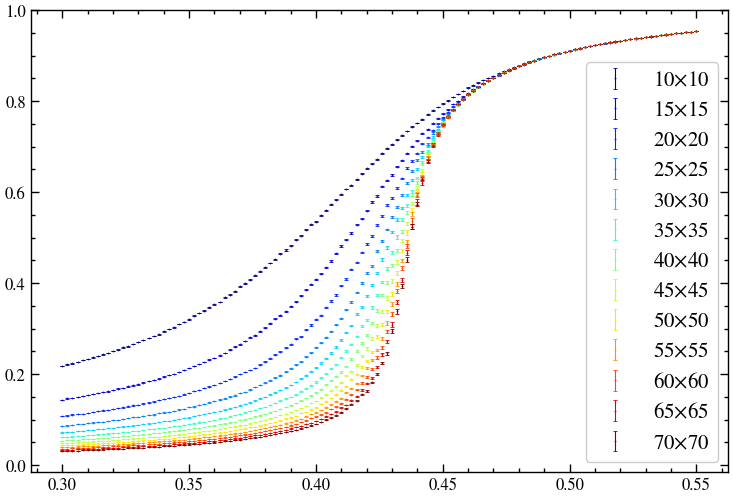

In [59]:
for i, file in enumerate(files):
  plt.errorbar(beta_exp, magns_L[:,i], dmagns_L[:,i],fmt='.',capthick =.6 ,capsize =1.3 , elinewidth=.8,linewidth=.5,markersize=.6,label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),i))
plt.grid(False)
plt.legend(loc='lower right')

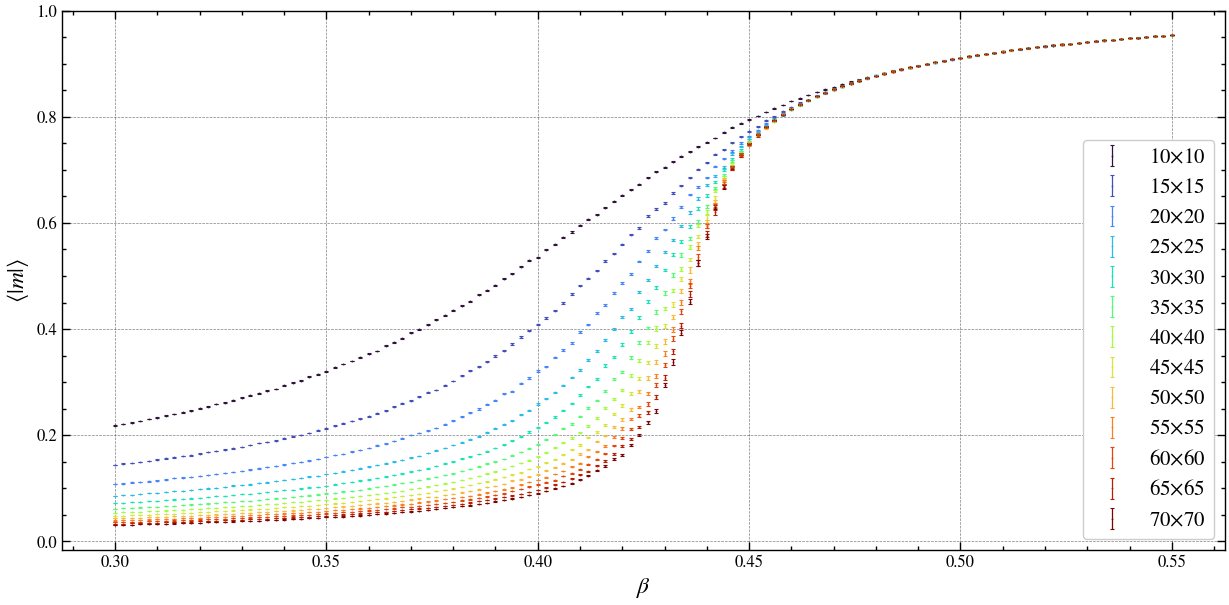

In [75]:
aa=np.arange(1,4000,1)
plt.figure(figsize=(15,7))
for i, file in enumerate(files):
  plt.errorbar(beta_exp, magns_L[:,i], dmagns_L[:,i],fmt='.',capthick =.8 ,capsize =1.4 , elinewidth=.9,linewidth=.5,markersize=.6,label=rf'{file}$ \times ${file}',color=getColor('turbo', len(files),i))

plt.ylabel(r'$\langle  |m|\rangle$')
plt.xlabel(r'$\beta$')
plt.legend(loc='lower right')



plt.savefig('onlym', dpi=500)

  0%|          | 0/13 [00:00<?, ?it/s]

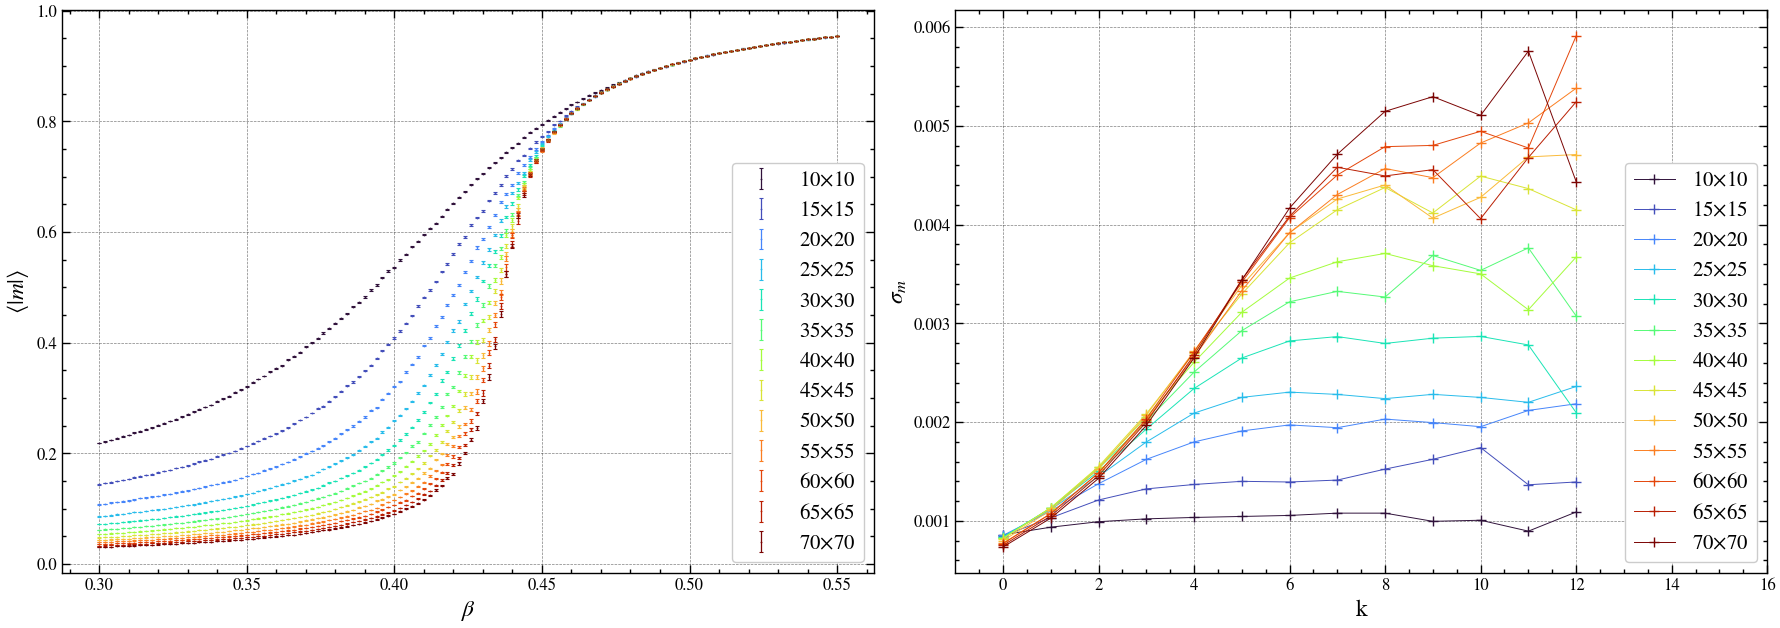

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(22, 7.3), sharey=False)
ax = axes[0]
for i, file in enumerate(files):
  ax.errorbar(beta_exp, magns_L[:,i], dmagns_L[:,i],fmt='.',capthick =.8 ,capsize =1.4 , elinewidth=.9,linewidth=.5,markersize=.6,label=rf'{file}$ \times ${file}',color=getColor('turbo', len(files),i))

ax.set_ylabel(r'$\langle  |m|\rangle$')
ax.set_xlabel(r'$\beta$')
ax.legend(loc='lower right')
fig.savefig('onlym', dpi=500)

ax = axes[1]
aa=np.arange(1,4000,1)
for i,file in enumerate(tqdm(files)):
    sigma_m_try =[]
    for k in range(0,13):
        dm_try = blocking(np.abs(magnes_mat[bs == 0.432, i][14464:]), 2**k)
        sigma_m_try.append(dm_try)
    ax.plot(list(range(0,13)) , sigma_m_try,'-+',markersize='7', linewidth='.7',label=rf'{file}$ \times ${file}',color=getColor('turbo', len(files),int(file/5 - 2)))
    
ax.legend(loc='lower right')
ax.set_ylabel(r'$\sigma_m$')
ax.set_xlabel(r'k')
ax.set_xlim(-1,16)
fig.subplots_adjust(wspace=.1, hspace=0)
#ax.set_yscale('log')
fig.savefig('magnetizzazione_blocking', dpi=500)

In [87]:
files

array([50, 55, 60, 65, 70])

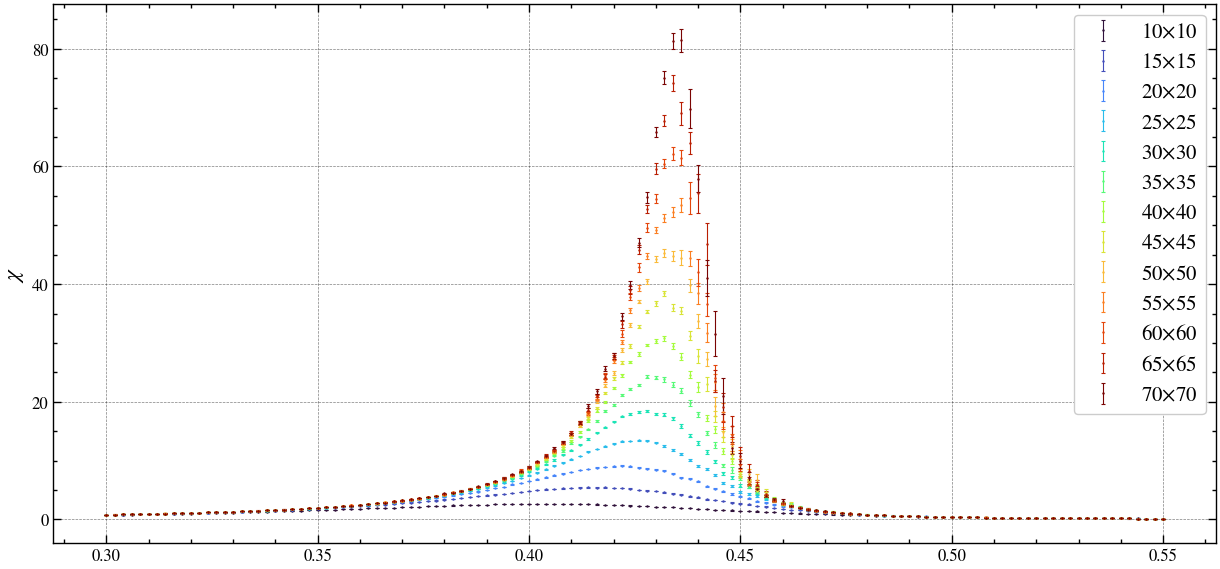

In [54]:
plt.figure(figsize=(15,7))
files = np.arange(10,75,5)
for i, file in enumerate(files):
  plt.errorbar(beta_exp, chi_L[:,i], dchi_L[:,i],fmt='.',capthick =.8 ,capsize =1.5 , elinewidth=.8,linewidth=.5,markersize=1.5,label=rf'{file}$ \times ${file}',color=getColor('turbo', len(files),i))
plt.legend(loc='upper right')
plt.ylabel(r'$\chi$')
plt.savefig('susc', dpi=(500))

In [85]:
2**10

1024

In [66]:
dchi_L[66,8], chi_L[66,8]

(1.3544882986752333, 104.56226977358193)

In [508]:
chose_block = np.arange(100,1100,100)
a= np.insert(chose_block, 0, (1,10,30,50))
a= np.append(a,(1500,3000,5000,7500,12500))
a

array([    1,    10,    30,    50,   100,   200,   300,   400,   500,
         600,   700,   800,   900,  1000,  1500,  3000,  5000,  7500,
       12500])

  0%|          | 0/6 [00:00<?, ?it/s]

(-10.0, 5000.0)

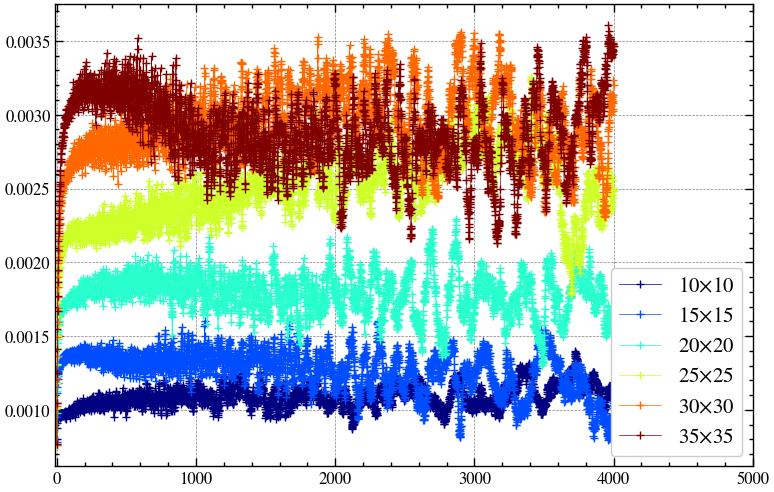

In [563]:
aa=np.arange(1,4000,1)
files = np.arange(10,40,5)
for i,file in enumerate(tqdm(files)):
    sigma_m_try =[]
    for k in aa:
        dm_try = blocking(np.abs(magnes_mat[bs == 0.436, i][10000:]), k)
        sigma_m_try.append(dm_try)
    plt.plot(aa , sigma_m_try,'-+',markersize='6', linewidth='.5',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
    
plt.legend(loc='lower right')
plt.xlim(-10,5000)

  0%|          | 0/13 [00:00<?, ?it/s]

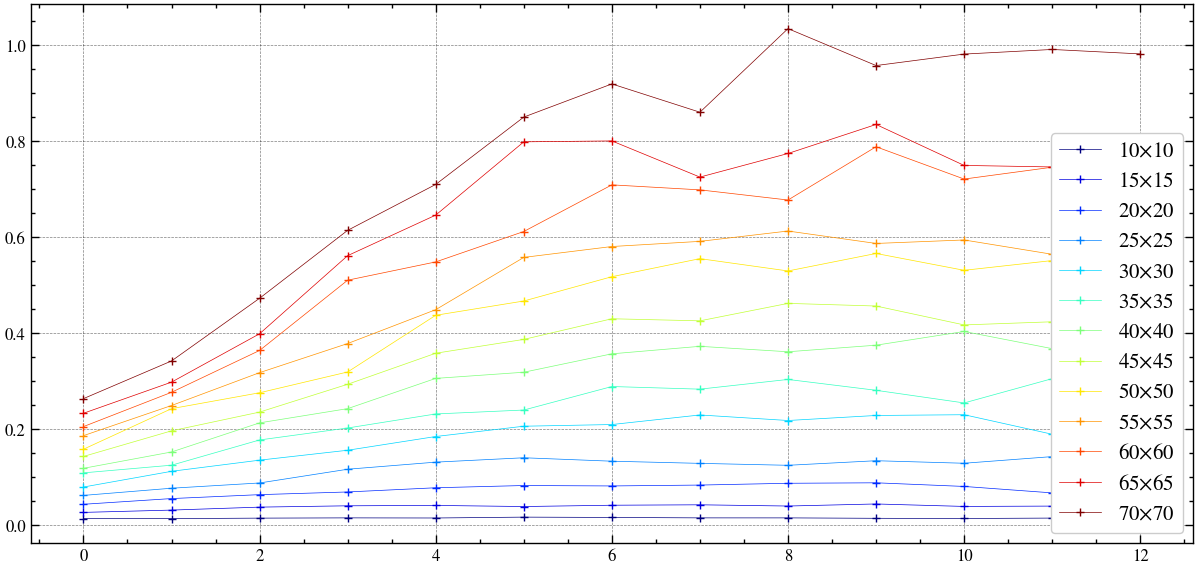

In [22]:
#best block/number of resamples beta=0.43
plt.figure(figsize=(15,7))
aa=np.arange(10,1000,10)
files = np.arange(10,75,5)
for i,file in enumerate(tqdm(files)):
    sigma_chi_try =[]
    for k in range(0,13):
        dchi_try = 0.432*file**2 * bootstrap_binned(np.abs(magnes_mat[bs == 0.432, i][:]), 2**k, var_abs, 300).std(ddof=1)
        sigma_chi_try.append(dchi_try)
    plt.plot(list(range(0,13)) , sigma_chi_try,'-+',markersize='6', linewidth='.5',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
   
plt.legend(loc='lower right')
plt.savefig('block_chi', dpi=(500))


In [86]:
bs

array([0.3 , 0.3 , 0.3 , ..., 0.55, 0.55, 0.55])

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

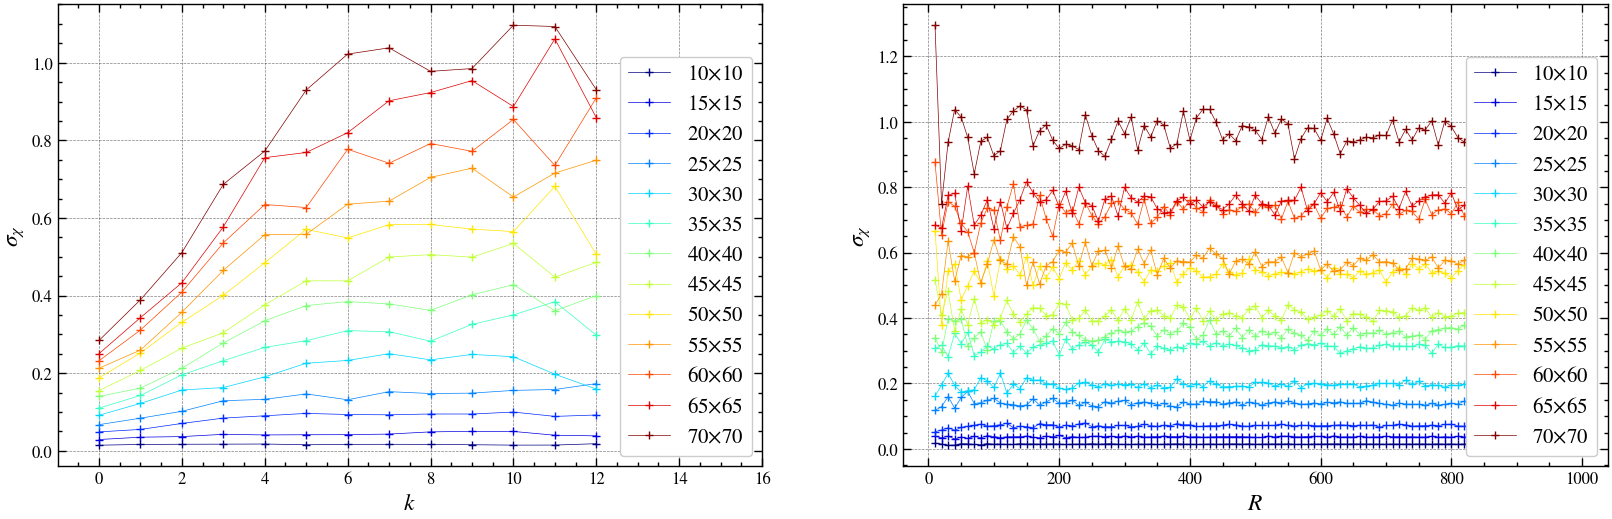

In [101]:
#best block/number of resamples beta=0.43
fig, axes = plt.subplots(1,2,figsize=(20,6))
ax = axes[1]
aa=np.arange(10,1000,10)
files = np.arange(10,75,5)
for i,file in enumerate(tqdm(files)):
    sigma_chi_try =[]
    for k in aa:
        dchi_try = 0.432*file**2 * bootstrap_binned(np.abs(magnes_mat[bs == 0.432, i][:]), 2048, var_abs, k).std(ddof=1)
        sigma_chi_try.append(dchi_try)
    ax.plot(aa , sigma_chi_try,'-+',markersize='6', linewidth='.5',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
ax.set_ylabel(r'$\sigma_{\chi}$')
ax.set_xlabel(r'$R$')
ax.legend(loc='lower right')

ax = axes[0]
for i,file in enumerate(tqdm(files)):
    sigma_chi_try =[]
    for k in range(0,13):
        dchi_try = 0.432*file**2 * bootstrap_binned(np.abs(magnes_mat[bs == 0.432, i][N:]), 2**k, var_abs, 300).std(ddof=1)
        sigma_chi_try.append(dchi_try)
    ax.plot(list(range(0,13)) , sigma_chi_try,'-+',markersize='6', linewidth='.5',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
ax.set_ylabel(r'$\sigma_{\chi}$')  
ax.set_xlabel(r'$k$')
ax.set_xlim(-1,16)
ax.legend(loc='lower right')

fig.savefig('blo_resa',dpi=500)

In [ ]:
aa=np.arange(1,4000,1)
files = np.arange(10,75,5)
for i,file in enumerate(tqdm(files)):
    sigma_m_try =[]
    for k in range(0,13):
        dm_try = blocking(np.abs(magnes_mat[bs == 0.432, i][14464:]), 2**k)
        sigma_m_try.append(dm_try)
    plt.plot(list(range(0,13)) , sigma_m_try,'-+',markersize='6', linewidth='.5',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
    
plt.legend(loc='lower right')
plt.xlim(-1,20)
plt.yscale('log')


In [98]:
len(magnes_mat[:,1])

10080000

In [100]:
80000*126

10080000

In [568]:
n=80000
n.bit_length()-1

16

In [36]:
DIR = os.getcwd() + '/test_bootstrap/'
nomi = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]
nomi = [name.replace('simulation_50_','') for name in nomi]
nomi = [name.replace('.txt','') for name in nomi]
nomi

['86',
 '92',
 '45',
 '51',
 '79',
 '119',
 '125',
 '131',
 '130',
 '124',
 '118',
 '78',
 '50',
 '44',
 '93',
 '87',
 '91',
 '85',
 '52',
 '46',
 '132',
 '126',
 '127',
 '133',
 '47',
 '53',
 '84',
 '90',
 '94',
 '80',
 '57',
 '43',
 '137',
 '123',
 '.DS_Store',
 '122',
 '136',
 '42',
 '56',
 '81',
 '95',
 '83',
 '97',
 '68',
 '40',
 '54',
 '9',
 '120',
 '134',
 '108',
 '109',
 '135',
 '121',
 '8',
 '55',
 '41',
 '69',
 '96',
 '82',
 '26',
 '32',
 '185',
 '191',
 '146',
 '152',
 '153',
 '147',
 '190',
 '184',
 '33',
 '27',
 '31',
 '25',
 '19',
 '192',
 '186',
 '179',
 '151',
 '145',
 '144',
 '150',
 '178',
 '187',
 '193',
 '18',
 '24',
 '30',
 '34',
 '20',
 '197',
 '183',
 '154',
 '140',
 '168',
 '169',
 '141',
 '155',
 '182',
 '196',
 '21',
 '35',
 '23',
 '37',
 '180',
 '194',
 '143',
 '157',
 '156',
 '142',
 '195',
 '181',
 '36',
 '22',
 '13',
 '198',
 '167',
 '173',
 '172',
 '166',
 '199',
 '12',
 '10',
 '38',
 '158',
 '170',
 '164',
 '165',
 '171',
 '159',
 '39',
 '11',
 '29',
 '1

In [97]:
#import tha data (only magnetizations) of the \sim 200 simulations for beta = 0.432 and n_latt=50 and do the statistics
direct='/test_bootstrap/'
filepath = os.getcwd()  + direct  + 'simulation_50_'
chis=[]
for i in range(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])-1):  #Ds store lol
    m = np.loadtxt(filepath + f'{i}.txt', usecols=1, unpack=True)
    chis.append((np.abs(m[N:]).var(ddof=1)*0.432 * 50**2))
res = np.std(chis, ddof=1)
res

0.549317055756158

In [102]:
chi_L[66,8],dchi_L[66,8]

(45.299995217736154, 0.6302816747329993)

In [78]:
beta_exp[66]

0.432

In [52]:
m = np.loadtxt(os.getcwd()+'/test_bootstrap/'+'simulation_50_0.txt',usecols=1, unpack=True)

# Fit and anlysis of the critical behaviour of the ising model 

In [103]:
direct='/data_6272/susceptibility/'
filepath = os.getcwd()  + direct  + 'chi_'
beta_max = [np.argmax(np.loadtxt(filepath + f'{file}.txt', usecols=1, unpack=True)) for file in files]

In [172]:
beta_exp[beta_max]

array([0.4  , 0.412, 0.422, 0.426, 0.428, 0.428, 0.432, 0.432, 0.432,
       0.436, 0.434, 0.434, 0.434])

In [173]:
def fit_bm(x, a, b, c):
    return a + b*(x**(-1/c))

ν = 0.831 ± 0.151
ν_exp = 1
T_c = 2.277 ± 0.014
T_c_exp = 2.269


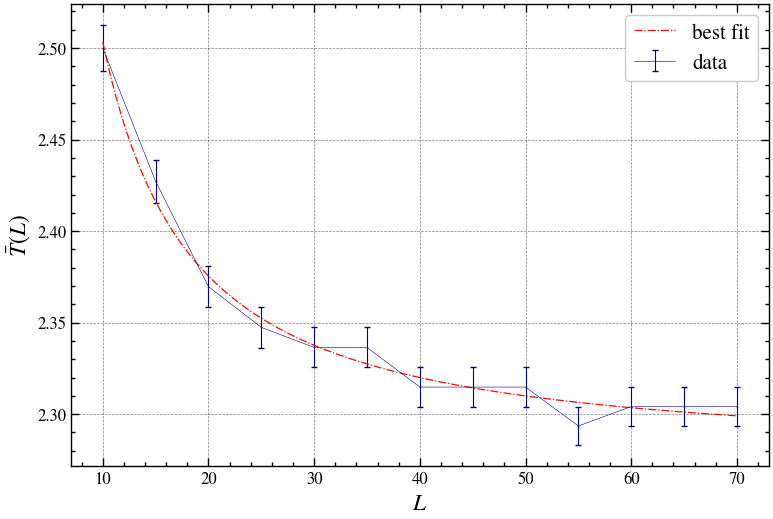

In [174]:

sigma_beta = (beta_exp[1]-beta_exp[0])
sigma_temp = sigma_beta/(beta_exp[beta_max]**2)

opt, cov = curve_fit(fit_bm, files, 1/beta_exp[beta_max],sigma = sigma_temp, absolute_sigma=True)
print(f'ν = {opt[2]:.3f} ± {np.sqrt(cov[2][2]):.3f}')
print(f'ν_exp = 1')
print(f'T_c = {opt[0]:.3f} ± {np.sqrt(cov[0][0]):.3f}')
print(f'T_c_exp = {2/np.log(1+np.sqrt(2)):.3f}')


plt.errorbar(files,1/beta_exp[beta_max] , sigma_temp,fmt='+-',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 1, 0))
X = np.linspace(min(files), max(files), 1000)
#plt.plot(X, fit_bm(X, *opt))
plt.plot(X , fit_bm(X, *opt),'-.',markersize='6', linewidth='.9',color=getColor('jet', 20,17), label='best fit')
plt.xlabel('$ L $')
plt.ylabel(r'$ \bar T(L) $')
plt.legend(loc='upper right')
plt.savefig('betacfirst', dpi=(500))
plt.show()

In [175]:
direct='/data_6272/susceptibility/'
filepath = os.getcwd()  + direct  + 'chi_'
beta_max = [np.argmax(np.loadtxt(filepath + f'{file}.txt', usecols=1, unpack=True)) for file in files]

In [176]:
beta_max

[50, 56, 61, 63, 64, 64, 66, 66, 66, 68, 67, 67, 67]

In [177]:
chi_L[(beta_max[12]-6):(beta_max[12]+6),12]

array([34.53663007, 39.83289728, 47.03079414, 54.74160702, 65.85933895,
       75.08942604, 81.33376485, 81.45931285, 69.85880785, 57.9512734 ,
       40.99704444, 31.5595379 ])

In [275]:
chi_fit = [chi_L[(beta_max[i]-7):(beta_max[i]+6),i] for i in range(len(files))]
dchi_fit = [dchi_L[(beta_max[i]-7):(beta_max[i]+6),i] for i in range(len(files))]

In [179]:
def fit_chimax(x, a, b, c):
    return a + b*(x-c)**2

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_42617/353494984.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 3, k+1)# Address proper subplot in 2x2 array


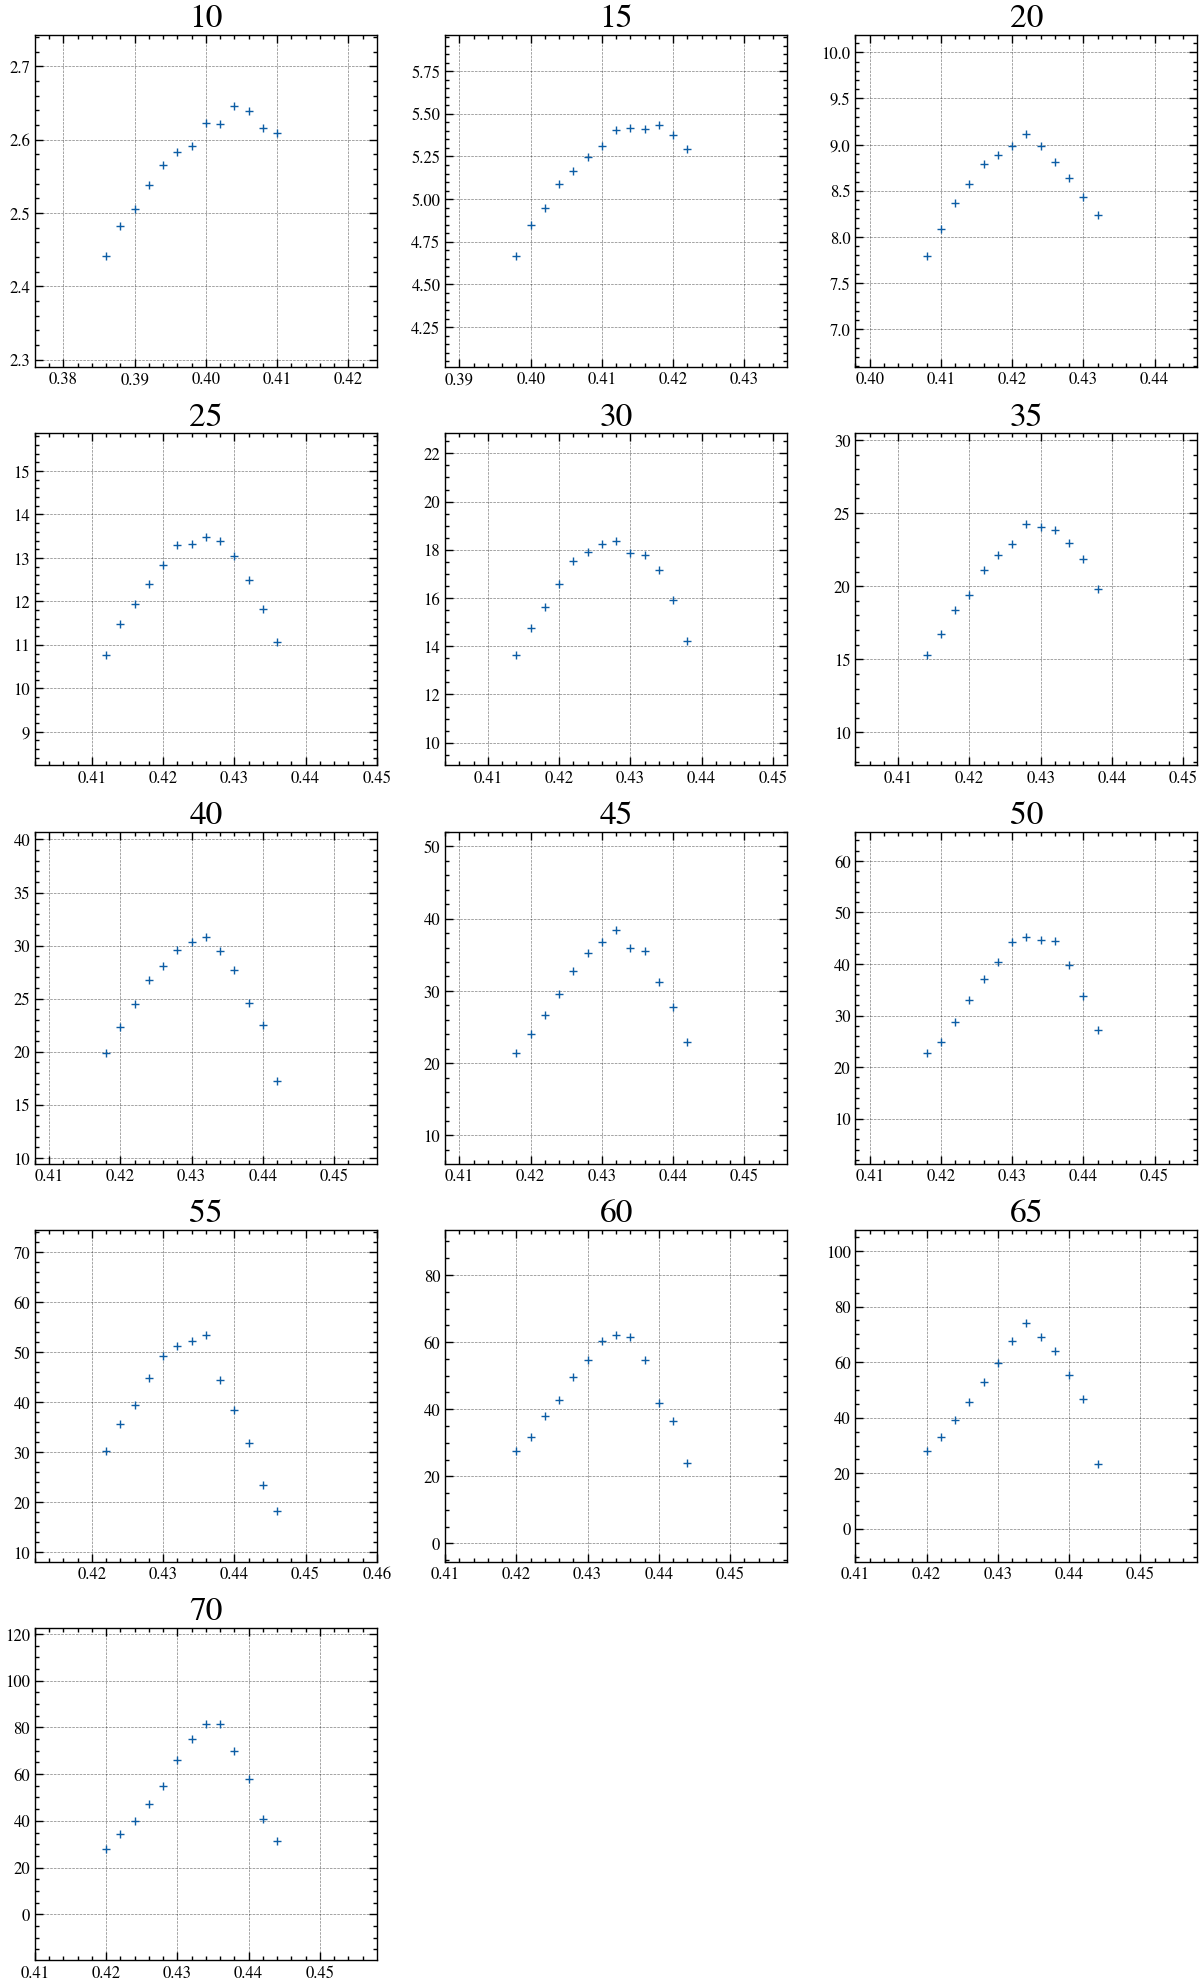

In [180]:
plt.figure(figsize=(15,25))
plt.title('') 
for k,file in enumerate(files):
     
    plt.subplot(5, 3, k+1)# Address proper subplot in 2x2 array
    plt.title(rf"{file}")
    plt.plot(beta_exp[(beta_max[k]-7):(beta_max[k]+6)],chi_fit[k],'+')
    plt.ylim(2*chi_fit[k][0]-1*chi_fit[k][6], 2*chi_fit[k][6] - chi_fit[k][0])
    plt.xlim(beta_exp[(beta_max[k]-7)]-0.01,beta_exp[(beta_max[k]+7)]+0.01 )
plt.show()

In [123]:
def fit_chilor(x, a, b, c, d):
    return a + (2*b)/np.pi * d/((x-c)**2 + d**2) 


$\beta_c$ = 0.4342 ± 0.0001
$y0$ = 10.2795 ± 1.8025
chi2, ndof: 31.109486814750163 9


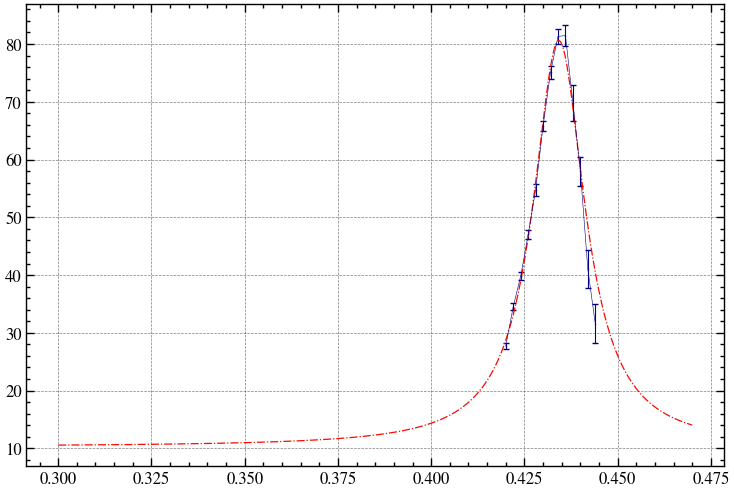

In [124]:
p0 = (-10 ,10,0.43,0.02 )
k=12
opt, cov = curve_fit(fit_chilor,beta_exp[(beta_max[k]-7):(beta_max[k]+6)][:],chi_fit[k][:],p0,sigma = dchi_fit[k][:], absolute_sigma=True)
w = 1/(dchi_fit[k][:]**2)
chi2 = ((w*(chi_fit[k][:]-fit_chilor(beta_exp[(beta_max[k]-7):(beta_max[k]+6)][:],*opt))**2)).sum()
ndof=len(beta_exp[(beta_max[k]-7):(beta_max[k]+6)][:])-len(p0)

print(fr'$\beta_c$ = {opt[2]:.4f} ± {np.sqrt(cov[2][2]):.4f}')
print(fr'$y0$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
print ('chi2, ndof:',chi2, ndof)

x=np.linspace(0.3,0.47,1000)
plt.errorbar(beta_exp[(beta_max[k]-7):(beta_max[k]+6)][:],chi_fit[k][:] , dchi_fit[k][:],fmt='+-',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 1, 0))
plt.plot(x , fit_chilor(x, *opt),'-.',markersize='6', linewidth='.9',color=getColor('jet', 20,17), label='best fit')





$\beta_c$ = 0.4337 ± 0.0002
chi2, ndof: 395.15813459234545 10


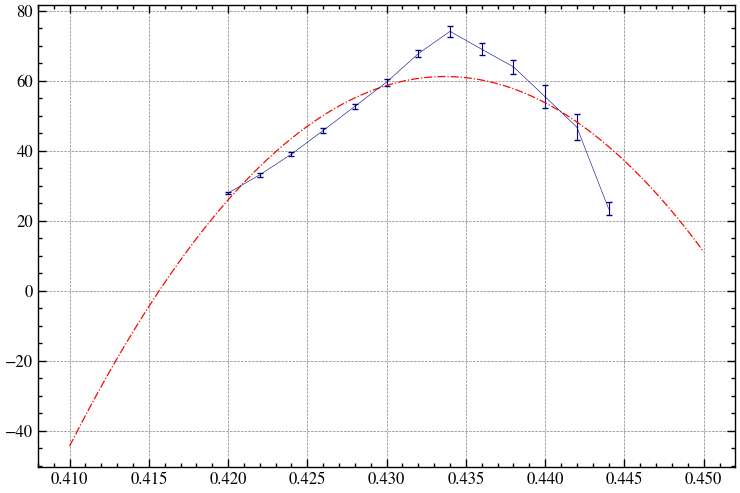

In [125]:
p0 = (150 ,-1,0.4339)  
k=11
opt, cov = curve_fit(fit_chimax,beta_exp[(beta_max[k]-7):(beta_max[k]+6)][:],chi_fit[k][:],p0,sigma = dchi_fit[k][:], absolute_sigma=True)
w = 1/(dchi_fit[k][:]**2)
chi2 = ((w*(chi_fit[k][:]-fit_chimax(beta_exp[(beta_max[k]-7):(beta_max[k]+6)][:],*opt))**2)).sum()
ndof=len(beta_exp[(beta_max[k]-7):(beta_max[k]+6)][:])-len(p0)

print(fr'$\beta_c$ = {opt[2]:.4f} ± {np.sqrt(cov[2][2]):.4f}')
#print(fr'$y0$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
print ('chi2, ndof:',chi2, ndof)

x=np.linspace(0.41,0.45,1000)
plt.errorbar(beta_exp[(beta_max[k]-7):(beta_max[k]+6)][:],chi_fit[k][:] , dchi_fit[k][:],fmt='+-',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 1, 0))
plt.plot(x , fit_chimax(x, *opt),'-.',markersize='6', linewidth='.9',color=getColor('jet', 20,17), label='best fit')

In [181]:
chi_fit,dchi_fit    #parametri
beta_exp[(beta_max[k]-7):(beta_max[k]+6)]  #indici
#now i'm gonna filter the previous lists with the indices selected before one by one by the fits

array([0.42 , 0.422, 0.424, 0.426, 0.428, 0.43 , 0.432, 0.434, 0.436,
       0.438, 0.44 , 0.442, 0.444])

In [276]:
beta_fit = [beta_exp[(beta_max[k]-7):(beta_max[k]+6)] for k in range(len(files))]

In [277]:

#0
chi_fit[0]  = chi_fit[0][:]
dchi_fit[0] = dchi_fit[0][:]
beta_fit[0] = beta_exp[(beta_max[0]-7):(beta_max[0]+6)][:]
#1
chi_fit[1]  = chi_fit[1][1:-1]
dchi_fit[1] = dchi_fit[1][1:-1]
beta_fit[1] = beta_exp[(beta_max[1]-7):(beta_max[1]+6)][1:-1]
#2
chi_fit[2]  = chi_fit[2]
dchi_fit[2] = dchi_fit[2]
beta_fit[2] = beta_exp[(beta_max[2]-7):(beta_max[2]+6)]
#3
chi_fit[3]  = chi_fit[3][2:-1]
dchi_fit[3] = dchi_fit[3][2:-1]
beta_fit[3] = beta_exp[(beta_max[3]-7):(beta_max[3]+6)][2:-1]
#4

chi_fit[4]  = chi_fit[4][:-2]
dchi_fit[4] = dchi_fit[4][:-2]
beta_fit[4] = beta_exp[(beta_max[4]-7):(beta_max[4]+6)][:-2]
#5
chi_fit[5]  = chi_fit[5][3:]
dchi_fit[5] = dchi_fit[5][3:]
beta_fit[5] = beta_exp[(beta_max[5]-7):(beta_max[5]+6)][3:]                       
#6
chi_fit[6]  = chi_fit[6][1:-1]
dchi_fit[6] = dchi_fit[6][1:-1]
beta_fit[6] = beta_exp[(beta_max[6]-7):(beta_max[6]+6)][1:-1]
#7
chi_fit[7]  = chi_fit[7][3:-1]
dchi_fit[7] = dchi_fit[7][3:-1]
beta_fit[7] = beta_exp[(beta_max[7]-7):(beta_max[7]+6)][3:-1]                       

#8
chi_fit[8]  = chi_fit[8][3:-1]
dchi_fit[8] = dchi_fit[8][3:-1]
beta_fit[8] = beta_exp[(beta_max[8]-7):(beta_max[8]+6)][3:-1]
#9
chi_fit[9]  = chi_fit[9][2:-1]
dchi_fit[9] = dchi_fit[9][2:-1]
beta_fit[9] = beta_exp[(beta_max[9]-7):(beta_max[9]+6)][2:-1]
#10
chi_fit[10]  = chi_fit[10][3:-1]
dchi_fit[10] = dchi_fit[10][3:-1]
beta_fit[10] = beta_exp[(beta_max[10]-7):(beta_max[10]+6)][3:-1]                       
#11
chi_fit[11]  = chi_fit[11][3:]
dchi_fit[11] = dchi_fit[11][3:]
beta_fit[11] = beta_exp[(beta_max[11]-7):(beta_max[11]+6)][3:]
#12
chi_fit[12]  = chi_fit[12][4:]
dchi_fit[12] = dchi_fit[12][4:]
beta_fit[12] = beta_exp[(beta_max[12]-7):(beta_max[12]+6)][4:]


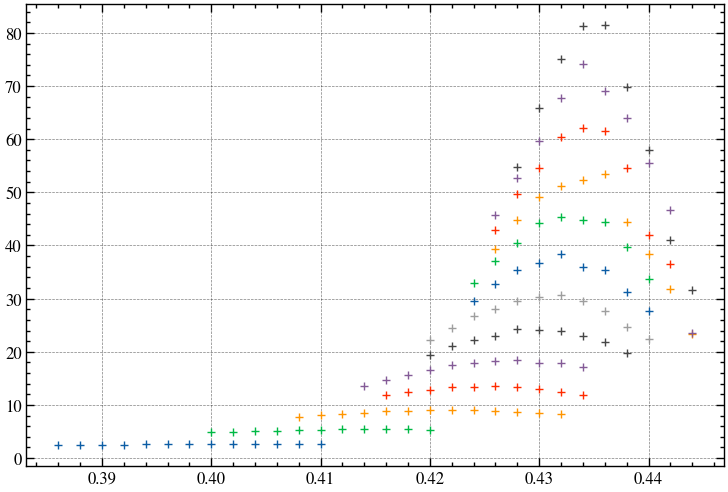

In [184]:
for i,f in enumerate(files):
    plt.plot(beta_fit[i],chi_fit[i],'+')

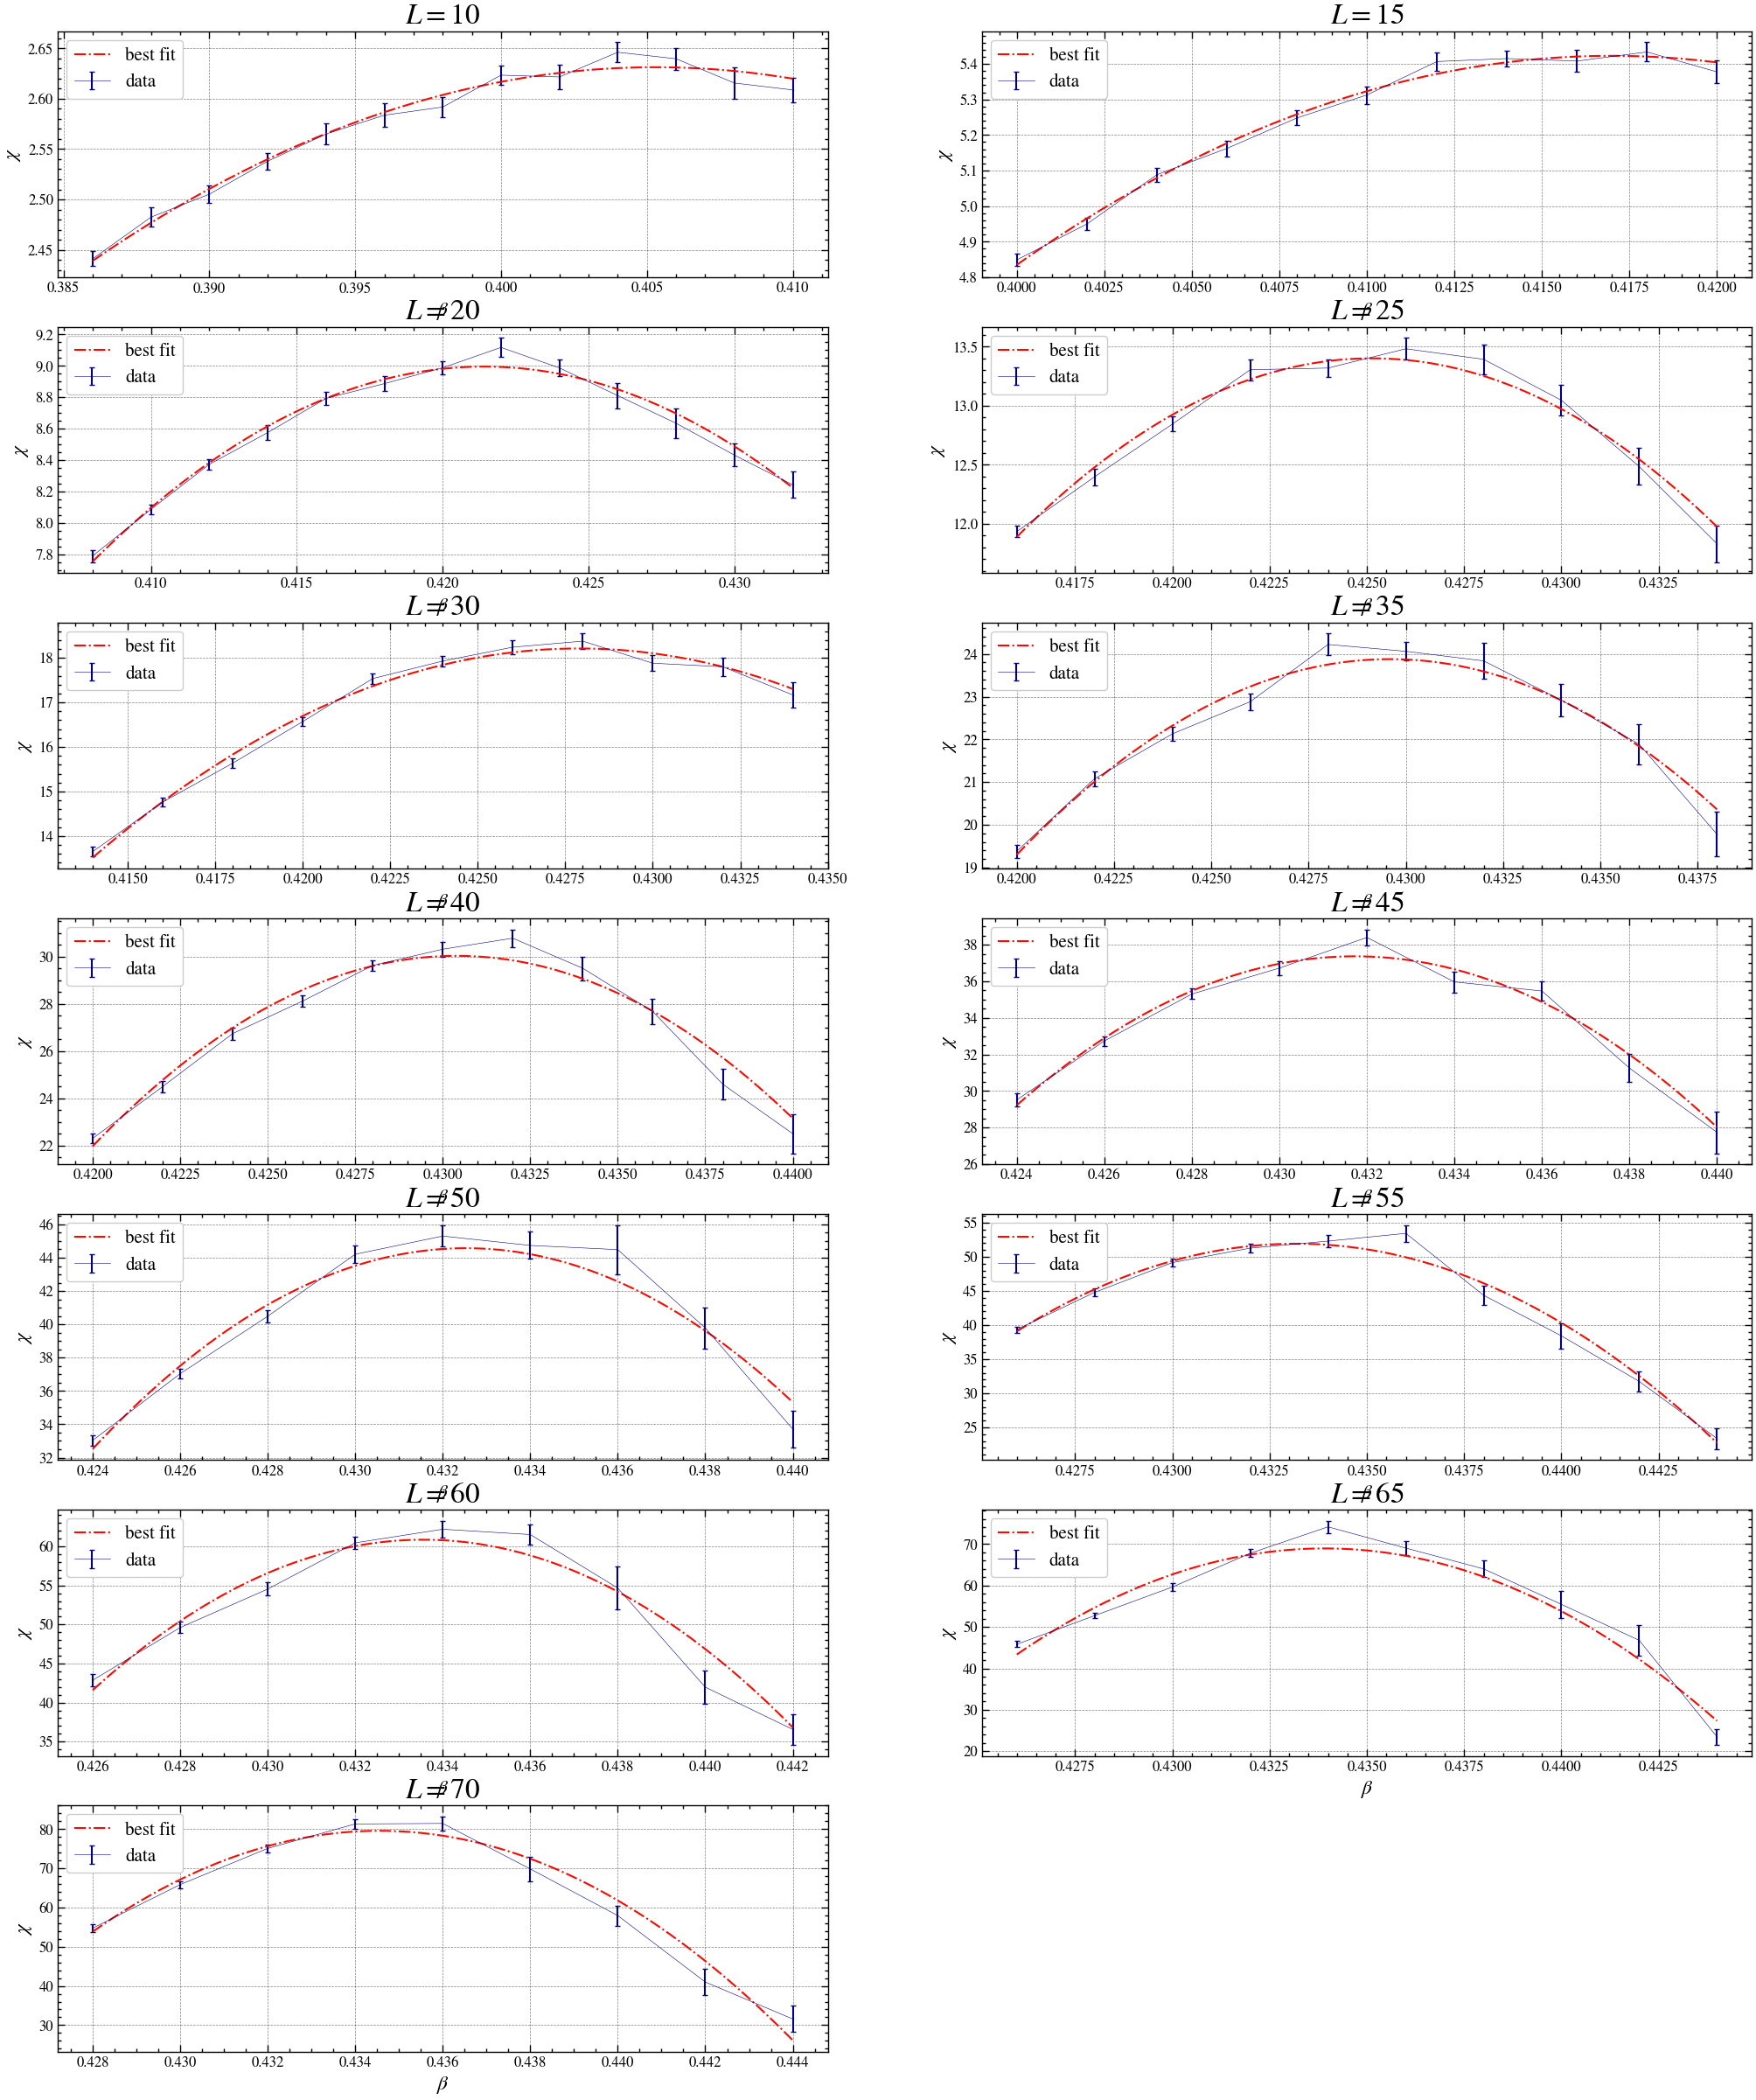

In [279]:
chi_square=[]
crit_bet=[]
dcrit_bet=[]
chis_max=[]
dchis_max=[]
plt.figure(figsize=(25,30))
for k,file in enumerate(files[:]):
    p0 = (110 ,-10,0.44)
    if (file>50) : p0 = (50 ,-1,0.432)
    opt, cov = curve_fit(fit_chimax,beta_fit[k],chi_fit[k],p0 ,sigma = dchi_fit[k], absolute_sigma=True)
    w = 1/(dchi_fit[k]**2)
    chi2 = ((w*(chi_fit[k]-fit_chimax(beta_fit[k],*opt))**2)).sum()
    ndof=len(beta_fit[k])-len(p0)
    chi_square.append(f'{chi2}/{ndof}')
    #print(fr'$\beta_c$ = {opt[2]:.4f} ± {np.sqrt(cov[2][2]):.4f}')
    crit_bet.append(opt[2])
    dcrit_bet.append(np.sqrt(cov[2][2]))
    chis_max.append(opt[0])
    dchis_max.append(np.sqrt(cov[0][0]))
    #print(fr'$y0$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
    #print ('chi2, ndof:',chi2, ndof)
    
    x=np.linspace(beta_fit[k][0],beta_fit[k][-1],1000)

    plt.subplot(7, 2, k+1)# Address proper subplot in 2x2 array
    plt.title(rf"$L = {file}$")
    plt.errorbar(beta_fit[k],chi_fit[k], dchi_fit[k],fmt='+-',capsize=2 , elinewidth=1.5,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 13, 0))
    plt.plot(x , fit_chimax(x, *opt),'-.',markersize='6', linewidth='1.5',color=getColor('jet', 20,17), label='best fit')
    plt.ylabel(r'$\chi$')
    plt.xlabel(r'$\beta$')
    #plt.plot(beta_exp[(beta_max[k]-7):(beta_max[k]+6)],chi_fit[k],'+')
    #plt.ylim(2*chi_fit[k][0]-1*chi_fit[k][6], 2*chi_fit[k][6] - chi_fit[k][0])
    #plt.xlim(beta_fit,beta_exp[(beta_max[k]+7)]+0.01 )
    plt.legend(loc='upper left')
#plt.savefig('fitmax')

In [202]:
    titolo_c = str(opt[0])
    titolo_dc = str(np.sqrt(cov[0][0]))


SyntaxError: invalid syntax (3538171920.py, line 3)

In [280]:
crit_bet

[0.4052996605685529,
 0.4169894616840516,
 0.421418820565202,
 0.4251314339304417,
 0.4278915735144083,
 0.4295915651021298,
 0.43039555951929626,
 0.43172372656150837,
 0.432528738409808,
 0.4331797259069883,
 0.4335584708396795,
 0.4339119544656772,
 0.43455528414108696]

In [281]:
dcrit_bet

[0.0009771479476638147,
 0.0008291134764070945,
 0.00019798963285587586,
 0.0001751898902178938,
 0.000324715528915216,
 0.00021511957064442077,
 0.00016779707069365958,
 0.00013957760467998235,
 0.00017902997739251456,
 0.00010763337460951622,
 0.00013473244266697562,
 0.00010001872406769525,
 0.00010464805977940185]

In [285]:
chi_square

['7.565641390116896/10',
 '5.616789030705477/8',
 '8.364784724990756/10',
 '8.960132738142764/7',
 '12.224644421059196/8',
 '11.116998346484536/7',
 '19.993898833277967/8',
 '11.113502545649956/6',
 '15.598766516665417/6',
 '12.927622776265613/7',
 '21.55091884148947/6',
 '49.75422259937818/7',
 '16.64293965131489/6']

In [283]:
chis_max

[2.631315537245482,
 5.422801027507279,
 8.995033200329662,
 13.401605029833599,
 18.209769085872836,
 23.87879274056525,
 30.02820392221176,
 37.372954508422104,
 44.57197976732082,
 51.91567905593882,
 60.85279271549006,
 68.93772424954582,
 79.58424178792042]

In [284]:
dchis_max

[0.004514154352053339,
 0.013081786049760994,
 0.02047677972347099,
 0.04128016500840374,
 0.06428078834743865,
 0.11289719295676762,
 0.13690667631416584,
 0.21124493756042376,
 0.3042554615088496,
 0.3934326195559661,
 0.5256080490024003,
 0.6270228932129447,
 0.7711965625770452]

$\chi_{max}(L) \propto (L)^{\gamma/\nu}  $

In [291]:
def fit_critici(x, a , b, d):
    return a + b*(x)**(d)

a = 0.19975 ± 0.32508
b = 0.04828 ± 0.00463
d = 1.74257 ± 0.02272
chi2, ndof: 11.558632131556903 7


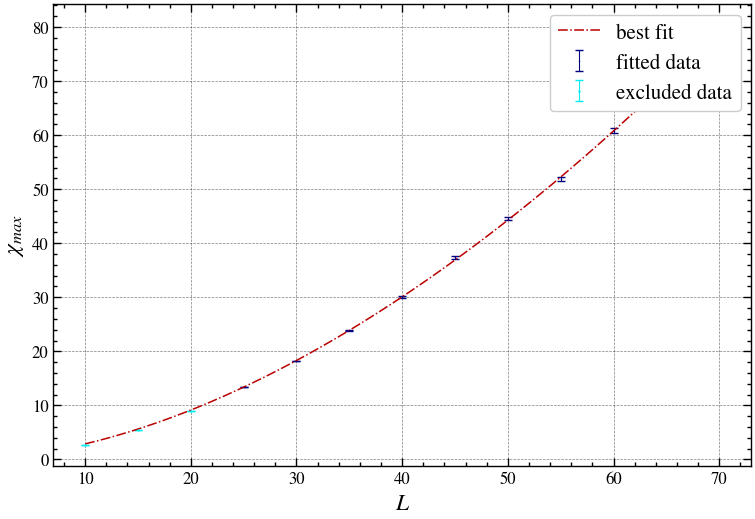

In [316]:
opt, cov = curve_fit(fit_critici, files[3:], chis_max[3:],sigma = dchis_max[3:], absolute_sigma=True)

w = 1/(np.array(dchis_max[3:])**2)
chi2 = ((w*(chis_max[3:]-fit_critici(files[3:],*opt))**2)).sum()
ndof=len(files[3:])    
    
    
print(f'a = {opt[0]:.5f} ± {np.sqrt(cov[0][0]):.5f}')
print(f'b = {opt[1]:.5f} ± {np.sqrt(cov[1][1]):.5f}')
print(f'd = {opt[2]:.5f} ± {np.sqrt(cov[2][2]):.5f}')
print ('chi2, ndof:',chi2, ndof-3)

plt.errorbar(files[3:],chis_max[3:] , dchis_max[3:],fmt='+',capthick=1,capsize=3 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'fitted data',color=getColor('jet', 15, 0))
plt.errorbar(files[:-10],chis_max[:-10] , dchis_max[:-10],fmt='+',capsize=3 , elinewidth=.8,linewidth=.4,markersize=2,label=rf'excluded data',color=getColor('jet', 15, 5))
x = np.linspace(min(files), max(files), 1000)
#plt.plot(X, fit_bm(X, *opt))
plt.plot(x , fit_critici(x, *opt),'-.',markersize='6', linewidth='1.1',color=getColor('jet', 20,18), label='best fit')
plt.xlabel('$ L $')
plt.ylabel(r'$\chi_{max}$')
plt.legend(loc='upper right')
plt.savefig('gamma-nu-3', dpi=500)
plt.show()

In [318]:
(1.75-1.74)/0.02

0.5000000000000004

The fact that the fit return the correct values only if we neglect the first three points is due to the fact that behaviour is expected for large value of $L$ 

a = 0.05953 ± 0.04660
b = 0.12429 ± 0.00225
d = 1.71739 ± 0.00508
chi2, ndof: 10.80992768130719 7


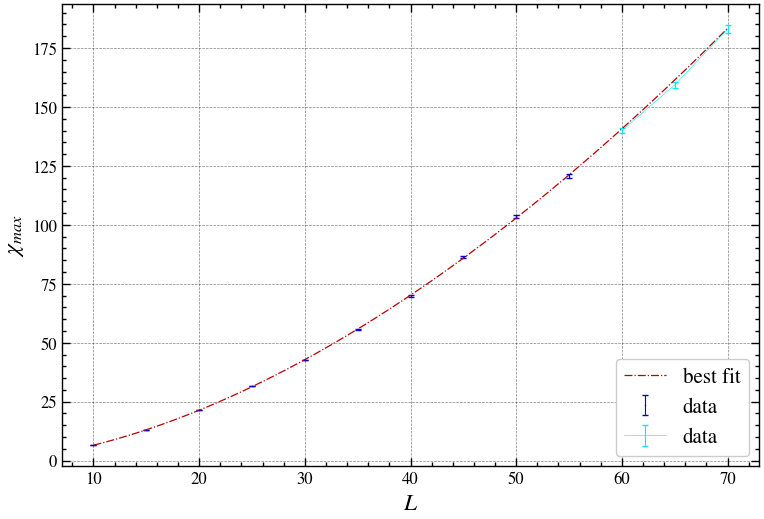

In [676]:
opt, cov = curve_fit(fit_critici, files[:-3], chis_max[:-3],sigma = dchis_max[:-3], absolute_sigma=True)

w = 1/(np.array(dchis_max[:-3])**2)
chi2 = ((w*(chis_max[:-3]-fit_critici(files[:-3],*opt))**2)).sum()
ndof=len(files[:-3])       
    
print(f'a = {opt[0]:.5f} ± {np.sqrt(cov[0][0]):.5f}')
print(f'b = {opt[1]:.5f} ± {np.sqrt(cov[1][1]):.5f}')
print(f'd = {opt[2]:.5f} ± {np.sqrt(cov[2][2]):.5f}')
print ('chi2, ndof:',chi2, ndof-3)

plt.errorbar(files[:-3],chis_max[:-3] , dchis_max[:-3],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 15, 1))
plt.errorbar(files[-3:],chis_max[-3:] , dchis_max[-3:],fmt='+-',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 15, 5))
x = np.linspace(min(files), max(files), 1000)
#plt.plot(X, fit_bm(X, *opt))
plt.plot(x , fit_critici(x, *opt),'-.',markersize='6', linewidth='.9',color=getColor('jet', 20,18), label='best fit')
plt.xlabel('$ L $')
plt.ylabel(r'$\chi_{max}$')
plt.legend(loc='lower right')
plt.show()

In [287]:
def fit_betac(x, a, b, d):
    return a+b*(1/x)**d

a = 0.44005 ± 0.00050
b = -0.32061 ± 0.03472
d = 0.95481 ± 0.04435
chi2, ndof: 15.107485696277594 10


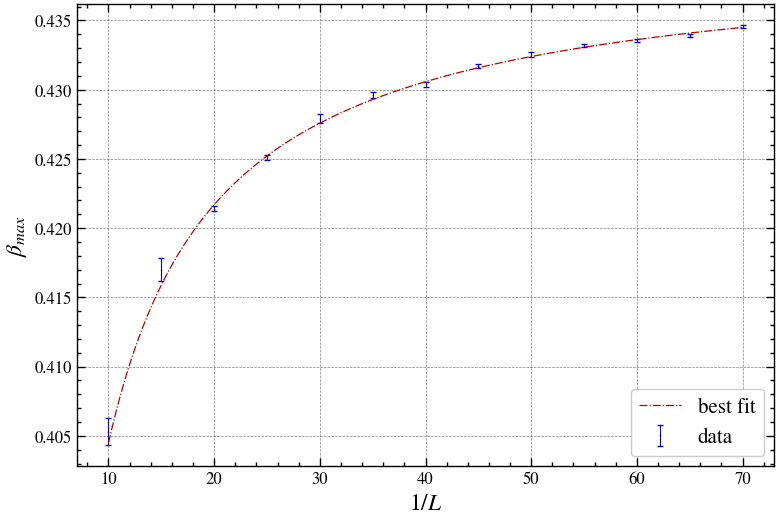

In [289]:
opt, cov = curve_fit(fit_betac, files, crit_bet,sigma = dcrit_bet, p0=(0.43, -1, 0.9), absolute_sigma=True)

w = 1/(np.array(dcrit_bet)**2)
chi2 = ((w*(crit_bet-fit_betac(files,*opt))**2)).sum()
ndof=len(files)       
    
print(f'a = {opt[0]:.5f} ± {np.sqrt(cov[0][0]):.5f}')
print(f'b = {opt[1]:.5f} ± {np.sqrt(cov[1][1]):.5f}')
print(f'd = {opt[2]:.5f} ± {np.sqrt(cov[2][2]):.5f}')
print ('chi2, ndof:',chi2, ndof-3)

plt.errorbar(files,crit_bet , dcrit_bet,fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 15, 1))

x = np.linspace(min(files), max(files), 1000)
#plt.plot(X, fit_bm(X, *opt))
plt.plot(x , fit_betac(x, *opt),'-.',markersize='6', linewidth='.9',color=getColor('jet', 20,18), label='best fit')
plt.xlabel(r'$ 1/L $')
plt.ylabel(r'$\beta_{max}$')
plt.legend(loc='lower right')
plt.savefig('stimabetacnu', dpi=500)

In [681]:
len(magnes_mat[bs==0.35,1])

80000

# Binder cumulant 

In [320]:
def cb(data):
    return ((data**4).mean())/(((data**2).mean())**2)

In [343]:
beta_exp

array([0.3  , 0.302, 0.304, 0.306, 0.308, 0.31 , 0.312, 0.314, 0.316,
       0.318, 0.32 , 0.322, 0.324, 0.326, 0.328, 0.33 , 0.332, 0.334,
       0.336, 0.338, 0.34 , 0.342, 0.344, 0.346, 0.348, 0.35 , 0.352,
       0.354, 0.356, 0.358, 0.36 , 0.362, 0.364, 0.366, 0.368, 0.37 ,
       0.372, 0.374, 0.376, 0.378, 0.38 , 0.382, 0.384, 0.386, 0.388,
       0.39 , 0.392, 0.394, 0.396, 0.398, 0.4  , 0.402, 0.404, 0.406,
       0.408, 0.41 , 0.412, 0.414, 0.416, 0.418, 0.42 , 0.422, 0.424,
       0.426, 0.428, 0.43 , 0.432, 0.434, 0.436, 0.438, 0.44 , 0.442,
       0.444, 0.446, 0.448, 0.45 , 0.452, 0.454, 0.456, 0.458, 0.46 ,
       0.462, 0.464, 0.466, 0.468, 0.47 , 0.472, 0.474, 0.476, 0.478,
       0.48 , 0.482, 0.484, 0.486, 0.488, 0.49 , 0.492, 0.494, 0.496,
       0.498, 0.5  , 0.502, 0.504, 0.506, 0.508, 0.51 , 0.512, 0.514,
       0.516, 0.518, 0.52 , 0.522, 0.524, 0.526, 0.528, 0.53 , 0.532,
       0.534, 0.536, 0.538, 0.54 , 0.542, 0.544, 0.546, 0.548, 0.55 ])

In [353]:
files = np.arange(10,75,5)
N=14464
cb1_list = np.zeros(len(files))
d_cb1_list = np.zeros(len(files))
cb2_list = np.zeros(len(files))
d_cb2_list = np.zeros(len(files))

#controlla problema degli abs
for i,file in enumerate(tqdm(files)):
    cbb1 = ((magnes_mat[bs==0.35,i][N:]**4).mean())/((magnes_mat[bs==0.35,i][N:]**2).mean())**2  
    cbb2 = ((magnes_mat[bs==0.45,i][N:]**4).mean())/((magnes_mat[bs==0.45,i][N:]**2).mean())**2    
    dcbb1 = bootstrap_binned(magnes_mat[bs==0.35,i][N:], 2048, cb, 300).std(ddof=1)    
    dcbb2 = bootstrap_binned(magnes_mat[bs==0.45,i][N:], 2048, cb, 300).std(ddof=1)    
    
    cb1_list[i] = cbb1
    cb2_list[i] = cbb2
    d_cb1_list[i] = dcbb1
    d_cb2_list[i] = dcbb2

  0%|          | 0/13 [00:00<?, ?it/s]

In [322]:
def fit_binder(x,a,b):
    return a + b*(x**2)

In [328]:
def fit_binder2(x,a,b, c):
    return a+ b/(x-c)

In [331]:
def fit_binder3(x,a,b):
    return a+b*x**(1/2)

<ErrorbarContainer object of 3 artists>

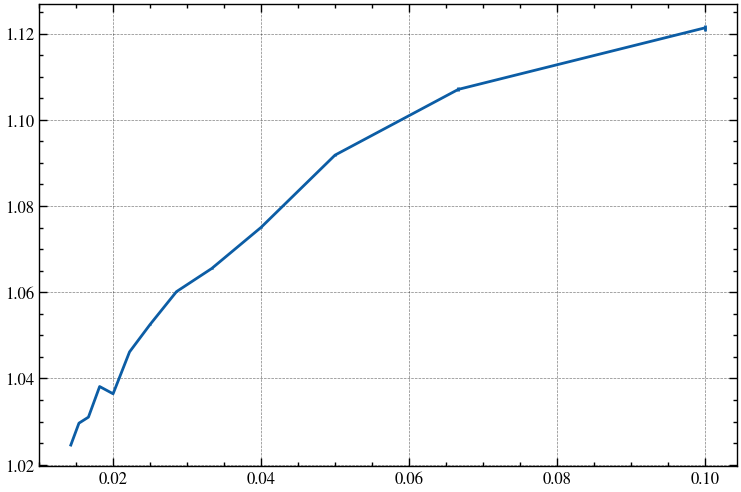

In [770]:
plt.errorbar(1/files, cb2_list, d_cb2_list)

In [350]:
(1-0.978)/0.007

3.1428571428571455

a = 2.99293 ± 0.00614
b = -92.58360 ± 3.04124
chi2, ndof: 10.1080074856239 9


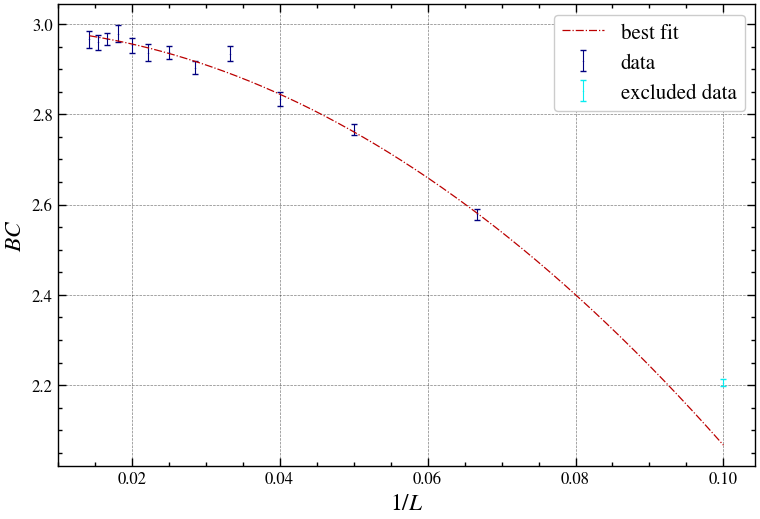

In [375]:
opt, cov = curve_fit(fit_binder, 1/files[1:], cb1_list[1:],sigma = d_cb1_list[1:], absolute_sigma=True)

w = 1/(np.array(d_cb1_list[1:])**2)
chi2 = ((w*(cb1_list[1:]-fit_binder(1/files[1:],*opt))**2)).sum()
ndof=len(files[1:])       
    
print(f'a = {opt[0]:.5f} ± {np.sqrt(cov[0][0]):.5f}')
print(f'b = {opt[1]:.5f} ± {np.sqrt(cov[1][1]):.5f}')
#print(f'd = {opt[2]:.5f} ± {np.sqrt(cov[2][2]):.5f}')
print ('chi2, ndof:',chi2, ndof-3)

plt.errorbar(1/files[1:],cb1_list[1:] , d_cb1_list[1:],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 15, 0))
plt.errorbar(1/files[0],cb1_list[0] , d_cb1_list[0],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'excluded data',color=getColor('jet', 15, 5))
x = np.linspace(min(1/files), max(1/files), 1000)

plt.plot(x , fit_binder(x, *opt),'-.',markersize='6', linewidth='.9',color=getColor('jet', 20,18), label='best fit')
plt.xlabel(r'$ 1/L $')
plt.ylabel(r'$BC$')
plt.legend(loc='upper right')
plt.savefig('disordinata', dpi=500)
plt.show()

a = 0.97193 ± 0.00763
b = 4.70961 ± 0.81512
c = -19.80141 ± 4.32593
chi2, ndof: 79913.36615533536 9


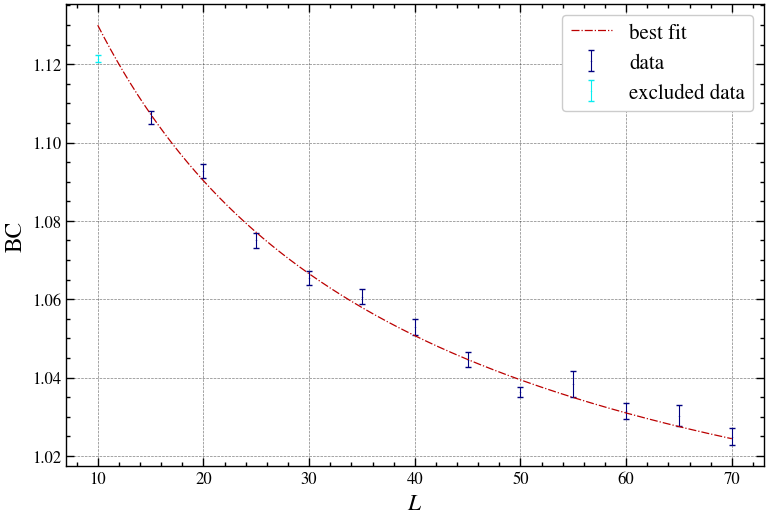

In [376]:
opt, cov = curve_fit(fit_binder2, files[1:], cb2_list[1:],sigma = d_cb2_list[1:], absolute_sigma=True)

w = 1/(np.array(d_cb2_list[1:])**2)
chi2 = ((w*(cb2_list[1:]-fit_binder2(1/files[1:],*opt))**2)).sum()
ndof=len(files[1:])       
    
print(f'a = {opt[0]:.5f} ± {np.sqrt(cov[0][0]):.5f}')
print(f'b = {opt[1]:.5f} ± {np.sqrt(cov[1][1]):.5f}')
print(f'c = {opt[2]:.5f} ± {np.sqrt(cov[2][2]):.5f}')
print ('chi2, ndof:',chi2, ndof-3)

plt.errorbar(files[1:],cb2_list[1:] , d_cb2_list[1:],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 15, 0))
plt.errorbar(files[0],cb2_list[0] , d_cb2_list[0],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'excluded data',color=getColor('jet', 15, 5))
x = np.linspace(min(files), max(files), 1000)

plt.plot(x , fit_binder2(x, *opt),'-.',markersize='6', linewidth='.9',color=getColor('jet', 20,18), label='best fit')
plt.xlabel(r'$ L $')
plt.ylabel('BC')
plt.legend(loc='upper right')
plt.savefig('ordinata', dpi=500)
plt.show()

a = 0.94817 ± 0.00011
b = 0.64673 ± 0.00086
chi2, ndof: 55024070.21416727 8


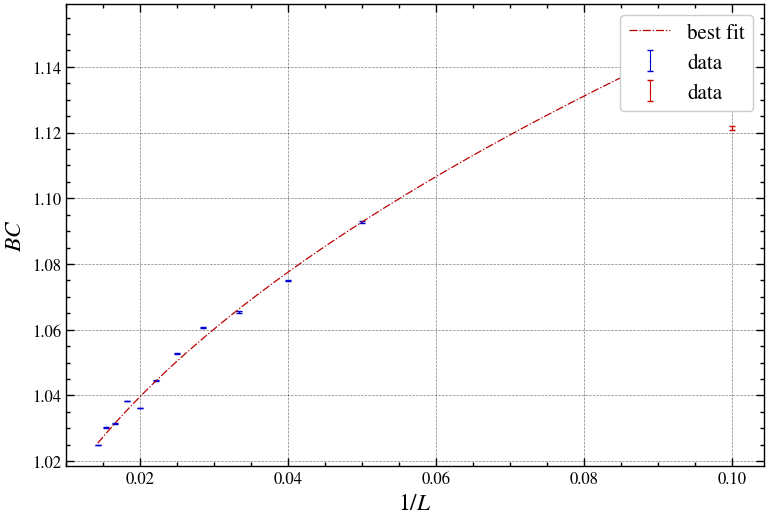

In [336]:
opt, cov = curve_fit(fit_binder3, 1/files[2:], cb2_list[2:],sigma = d_cb2_list[2:], absolute_sigma=True)

w = 1/(np.array(d_cb2_list[2:])**2)
chi2 = ((w*(cb2_list[2:]-fit_binder(1/files[2:],*opt))**2)).sum()
ndof=len(files[2:])       
    
print(f'a = {opt[0]:.5f} ± {np.sqrt(cov[0][0]):.5f}')
print(f'b = {opt[1]:.5f} ± {np.sqrt(cov[1][1]):.5f}')
#print(f'd = {opt[2]:.5f} ± {np.sqrt(cov[2][2]):.5f}')
print ('chi2, ndof:',chi2, ndof-3)

plt.errorbar(1/files[2:],cb2_list[2:] , d_cb2_list[2:],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 15, 1))
plt.errorbar(1/files[0],cb2_list[0] , d_cb2_list[0],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data',color=getColor('jet', 15, 13))
x = np.linspace(min(1/files), max(1/files), 1000)

plt.plot(x , fit_binder3(x, *opt),'-.',markersize='6', linewidth='.9',color=getColor('jet', 20,18), label='best fit')
plt.xlabel(r'$ 1/L $')
plt.ylabel(r'$BC$')
plt.legend(loc='upper right')
plt.show()

  0%|          | 0/13 [00:00<?, ?it/s]

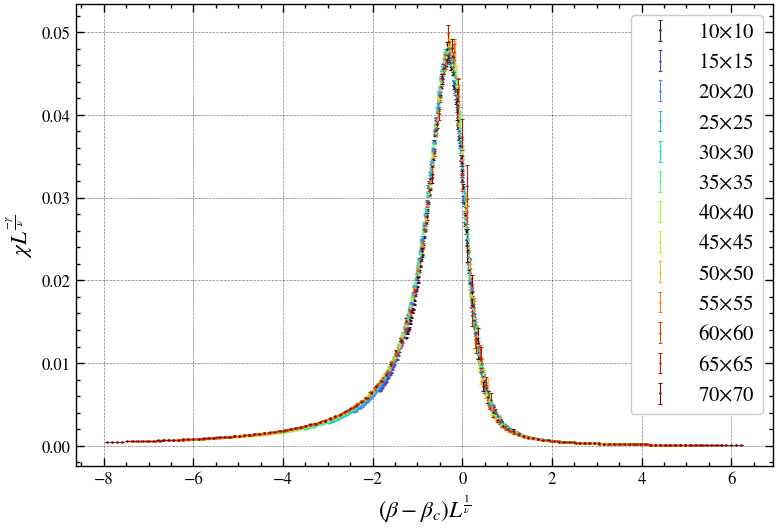

In [374]:

files = np.arange(10,75,5)
for i, file in enumerate(tqdm(files[:])):
  plt.errorbar((beta_exp-0.440)*file**(0.95), chi_L[:,i]/(file)**(1.75), dchi_L[:,i]/(file)**(1.75),fmt='.',capthick =.8 ,capsize =1.5 , elinewidth=0.8,linewidth=.0,markersize=1.5,label=rf'{file}$ \times ${file}',color=getColor('turbo', len(files),i))
plt.legend(loc='upper right')
plt.ylabel(r'$\chi  L^{\frac{-\gamma}{\nu}}$')
plt.xlabel(r'$(\beta - \beta_c)L^{\frac{1}{\nu}}$')
plt.savefig('fss', dpi=(500))